In [1]:
#ensembling
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert
from sklearn.neighbors import KNeighborsClassifier
from sklearn_crfsuite import scorers, CRF
from sklearn.pipeline import Pipeline
import json
from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite.metrics import sequence_accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import classes
import pickle
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import re

In [2]:
dir_name='duplicate'
seq_len=15
step=15
cv_split_name='cv_splits_per_client'
merged_str='scaled.binary0.50_merged'
doc_indices=np.arange(1,81)
final_name='merged.crf.bert.ens.base.c.w.l'#"merged.crf.bert.ens.c.w.l" #'bert.crf.ridge.full_split'#'bert.crf.svc.per.client'
doc_indices
test_doc_num=8
seed=42

In [6]:
# crf_feat_name='crf.per.client.features'
# crf_feat_name='crf.per.client.features.no.lemma'
# crf_feat_name="new.crf.features"
# crf_feat_name='crf.features.tf.per.split.char.lemma.word.full.splits'
crf_feat_name='crf.features.tf.per.split.char.lemma.word.full.splits.c.w.l'

In [7]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [8]:
use_neg=0

### Find best combination of features for CRF 

In [9]:
crf_prefix='crf.split.report.tf.per.split'

In [9]:
crf_list = glob.glob(os.path.join(os.path.join(
        os.getcwd(), defines.PATH_TO_DFS, dir_name, crf_prefix+"*")))
crf_list

['/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.split.report.tf.per.split.all.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.split.report.tf.per.split.word.char.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.split.report.tf.per.split.word.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.split.report.tf.per.split.char.csv']

In [22]:
crf_score_db={}
for crf in crf_list:
    name='_'.join(os.path.basename(crf).split('.')[6:])
    crf_score_db[name]=pd.read_csv(crf)
    print(name)
    display(crf_score_db[name])

all_csv


,label,sent_f1,sent_recall,sent_prec
0,not_nar,0.853,0.875,0.833
1,is_nar,0.503,0.463,0.569
2,weighted avg,0.772,0.780,0.772


word_char_csv


,label,sent_f1,sent_recall,sent_prec
0,not_nar,0.856,0.880,0.835
1,is_nar,0.510,0.471,0.571
2,weighted avg,0.776,0.783,0.775


word_csv


,label,sent_f1,sent_recall,sent_prec
0,not_nar,0.858,0.893,0.827
1,is_nar,0.490,0.432,0.587
2,weighted avg,0.772,0.784,0.772


char_csv


,label,sent_f1,sent_recall,sent_prec
0,not_nar,0.854,0.875,0.834
1,is_nar,0.504,0.466,0.564
2,weighted avg,0.773,0.781,0.772


In [20]:
compare_crf_db=pd.DataFrame()

compare_db=pd.concat([v.iloc[2,:] for v in crf_score_db.values()],axis=1)

In [21]:
compare_db

,2,2,2,2
label,weighted avg,weighted avg,weighted avg,weighted avg
sent_f1,0.772,0.776,0.772,0.773
sent_recall,0.78,0.783,0.784,0.781
sent_prec,0.772,0.775,0.772,0.772


### Separate lexical  & non-lexical features

In [288]:
imp.reload(common_utils)
crf_cv_features=common_utils.load_db(dir_name,crf_feat_name)

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.features.tf.per.split.char.lemma.word.full.splits.c.w.l.csv,  index False


In [292]:
commoin_f=crf_cv_features.dropna(how='any').query('label == @pos_l').shape[0]
commoin_f

24568

In [293]:
crf_cv_features.drop(columns=['Unnamed: 0'],inplace=True)

In [294]:
weight_indixes=crf_cv_features.columns.str.contains('weight')
weight_columns=crf_cv_features.columns[weight_indixes]
weight_columns


Index(['weight_1', 'weight_2', 'weight_3', 'weight_4', 'weight_5', 'weight_6',
       'weight_7', 'weight'],
      dtype='object')

In [295]:
crf_cv_features[weight_columns]=crf_cv_features[weight_columns].fillna(0)

In [296]:
crf_cv_features['mean']=crf_cv_features.loc[:,weight_indixes].mean(axis=1,numeric_only=True)

In [297]:
crf_cv_features

,weight_1,label,attr,type,str,weight_2,weight_3,weight_4,weight_5,weight_6,weight_7,weight,mean
0,1.39500,is_nar,is_client,NaN,NaN,1.48900,1.43500,1.71200,1.81900,1.52400,1.53600,1.53300,1.55537
1,0.82900,not_nar,+1:is_client,NaN,NaN,0.96100,0.98900,1.11800,1.15500,0.96800,0.87500,0.85900,0.96925
2,0.59200,not_nar,-1:sent_pos_in_par,NaN,NaN,0.69600,0.69100,0.61200,0.68900,0.60000,0.62700,0.50900,0.62700
3,0.57700,is_nar,sent_len,NaN,NaN,0.69600,0.72500,0.77800,0.77100,0.72500,0.68500,0.60800,0.69562
4,0.57500,is_nar,sent_pos_in_par,NaN,NaN,0.65500,0.61800,0.72500,0.66200,0.53900,0.63600,0.52400,0.61675
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80381,0.00000,not_nar,char.צינור,char,צינור,0.00000,0.00000,0.00000,0.00000,0.00000,0.00100,0.00000,0.00013
80382,0.00000,not_nar,lemma.צינור,lemma,צינור,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000
80383,0.00000,is_nar,lemma.צינור,lemma,צינור,0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000
80384,0.00000,is_nar,char.צינור,char,צינור,0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00100,-0.00000,-0.00013


In [298]:
pos_l='is_nar'
total_f_num=crf_cv_features.query('label == @pos_l').shape[0]
total_f_num

38639

In [546]:
crf_cv_features.query('label' == @pos_l')['mean'].min(),crf_cv_features.groupby('label')['mean'].max()

(label
 is_nar    -0.96925
 not_nar   -1.55537
 Name: mean, dtype: float64,
 label
 is_nar    1.55537
 not_nar   0.96925
 Name: mean, dtype: float64)

In [299]:
meta_f_num=crf_cv_features[(crf_cv_features['label'] == pos_l)&(crf_cv_features['type'].isna())].shape[0]
meta_f_num

401

In [300]:
meta_f_num/total_f_num

0.01037811537565672

In [301]:
commoin_f/total_f_num

0.6358342607210331

In [302]:
common_utils.save_db(crf_cv_features,dir_name,crf_feat_name+'filled')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.features.tf.per.split.char.lemma.word.full.splits.c.w.lfilled.csv, 
index False
float_format %.5f


In [549]:
crf_cv_features[crf_cv_features['str'].isna()].describe()

,weight_1,weight_2,weight_3,weight_4,weight_5,weight_6,weight_7,weight,mean
count,804.00000,804.00000,804.00000,804.00000,804.00000,804.00000,804.00000,804.00000,804.00000
mean,0.00005,0.00006,0.00005,0.00006,0.00025,0.00005,0.00005,0.00012,0.00009
std,0.14470,0.16105,0.15864,0.17914,0.18706,0.16365,0.16048,0.15810,0.16136
min,-1.39500,-1.48900,-1.43500,-1.71200,-1.81900,-1.52400,-1.53600,-1.53300,-1.55537
25%,-0.05500,-0.05800,-0.05800,-0.06625,-0.06700,-0.06400,-0.06000,-0.06200,-0.05866
50%,0.00050,0.00200,0.00100,0.00150,0.00150,0.00100,0.00100,0.00000,0.00156
75%,0.05500,0.05800,0.05800,0.06625,0.06700,0.06400,0.06000,0.06200,0.05866
max,1.39500,1.48900,1.43500,1.71200,1.81900,1.52400,1.53600,1.53300,1.55537


In [563]:
crf_cv_features[(crf_cv_features['label']=='is_nar')&(~crf_cv_features['str'].isna())]['mean'].describe()[['min','max']]

min   -0.36325
max    0.65800
Name: mean, dtype: float64

In [562]:
crf_cv_features[(crf_cv_features['label']=='is_nar')&(crf_cv_features['str'].isna())]['mean'].describe()[['min','max']]

min   -0.96925
max    1.55537
Name: mean, dtype: float64

In [560]:
crf_cv_features[(crf_cv_features['label']=='not_nar')&(~crf_cv_features['str'].isna())]['mean'].describe()[['min','max']]

min   -0.65800
max    0.36325
Name: mean, dtype: float64

In [561]:
crf_cv_features[(crf_cv_features['label']=='not_nar')&(crf_cv_features['str'].isna())]['mean'].describe()[['min','max']]

min   -1.55537
max    0.96925
Name: mean, dtype: float64

In [304]:
crf_cv_features.shape[0]

80386

In [305]:
crf_cv_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80386 entries, 0 to 80385
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   weight_1  80386 non-null  float64
 1   label     80386 non-null  object 
 2   attr      80386 non-null  object 
 3   type      79582 non-null  object 
 4   str       79582 non-null  object 
 5   weight_2  80386 non-null  float64
 6   weight_3  80386 non-null  float64
 7   weight_4  80386 non-null  float64
 8   weight_5  80386 non-null  float64
 9   weight_6  80386 non-null  float64
 10  weight_7  80386 non-null  float64
 11  weight    80386 non-null  float64
 12  mean      80386 non-null  float64
dtypes: float64(9), object(4)
memory usage: 8.0+ MB


In [306]:
# del crf_cv_features

In [307]:
tf_f_num=crf_cv_features[~crf_cv_features['type'].isna()].shape[0]
print(tf_f_num,tf_f_num/crf_cv_features.shape[0])

79582 0.9899982584032045


In [308]:
neighbor_f_num=crf_cv_features[crf_cv_features['type'].isna()].shape[0]
print(neighbor_f_num,neighbor_f_num*100/(crf_cv_features.shape[0]-tf_f_num))

804 100.0


In [309]:
nar_pos=crf_cv_features[(crf_cv_features['label']=='is_nar')&(crf_cv_features['mean']>0)][['mean','attr','type','str']].sort_values(by='mean',ascending=False).reset_index(drop=True).copy()
nar_neg=crf_cv_features[(crf_cv_features['label']=='is_nar')&(crf_cv_features['mean']<0)][['mean','attr','type','str']].sort_values(by='mean',ascending=True).reset_index(drop=True).copy()

In [310]:
nar_neg

,mean,attr,type,str
0,-0.96925,+1:is_client,NaN,NaN
1,-0.62700,-1:sent_pos_in_par,NaN,NaN
2,-0.42688,+1:TOKEN,NaN,NaN
3,-0.40025,POSTAG_NNP,NaN,NaN
4,-0.37638,f_per_2,NaN,NaN
...,...,...,...,...
17504,-0.00000,char.המש,char,המש
17505,-0.00000,char.למות,char,למות
17506,-0.00000,char.וימ,char,וימ
17507,-0.00000,char.עייתי,char,עייתי


### Meta-features

In [441]:
percent_of_pos=90

In [489]:
crf_cv_features[(crf_cv_features['type'].isna())&(crf_cv_features['label']=='is_nar')]['mean'].describe()

count   401.00000
mean     -0.01658
std       0.16081
min      -0.96925
25%      -0.07888
50%      -0.01763
75%       0.03338
max       1.55537
Name: mean, dtype: float64

In [490]:
crf_cv_features[~(crf_cv_features['type'].isna())&(crf_cv_features['label']=='is_nar')]['mean'].describe()

count   38238.00000
mean        0.00233
std         0.02497
min        -0.36325
25%        -0.00534
50%         0.00100
75%         0.00888
max         0.65800
Name: mean, dtype: float64

In [491]:
nar_pos_meta=nar_pos[nar_pos['type'].isna()].copy()
nar_neg_meta=nar_neg[nar_neg['type'].isna()].copy()

In [492]:
pos_threshold=np.percentile(nar_pos_meta['mean'],percent_of_pos)
pos_threshold

0.21915000000000007

In [493]:
neg_threshold=np.percentile(nar_neg_meta['mean'],5)
neg_threshold

-0.265825

In [494]:
nar_pos_meta=nar_pos_meta[nar_pos_meta['mean']>=pos_threshold]

In [495]:
nar_pos_meta

,mean,attr,type,str
0,1.55537,is_client,NaN,NaN
1,0.69562,sent_len,NaN,NaN
3,0.61675,sent_pos_in_par,NaN,NaN
5,0.56587,f_tense_PAST,NaN,NaN
6,0.52625,TOKEN,NaN,NaN
7,0.43513,-1:POSTAG_INTJ,NaN,NaN
9,0.40062,f_per_1,NaN,NaN
12,0.33963,+3:sent_pos_in_doc,NaN,NaN
18,0.30800,-3:POSTAG_REL,NaN,NaN
22,0.29900,+1:is_question,NaN,NaN


In [496]:
nar_pos_meta.shape[0],nar_neg_meta.shape[0]

(17, 239)

In [497]:
nar_neg_meta=nar_neg_meta[nar_neg_meta['mean']<neg_threshold]
nar_neg_meta.sort_values(by='mean',inplace=True,ascending=False)
nar_neg_meta

,mean,attr,type,str
16,-0.26875,is_question,NaN,NaN
11,-0.31712,-1:POSTAG_VB,NaN,NaN
10,-0.32088,+1:f_per_1,NaN,NaN
9,-0.33175,+1:POSTAG_COP,NaN,NaN
8,-0.33175,POSTAG_INTJ,NaN,NaN
7,-0.36225,-2:is_client,NaN,NaN
5,-0.36375,-1:TOKEN,NaN,NaN
4,-0.37638,f_per_2,NaN,NaN
3,-0.40025,POSTAG_NNP,NaN,NaN
2,-0.42688,+1:TOKEN,NaN,NaN


In [498]:
if(use_neg):
    nar_meta=pd.concat([nar_pos_meta,nar_neg_meta],axis=0)#.drop('string',axis=1) #,ignore_index=True)
    nar_meta.reset_index(inplace=True)
    nar_meta.rename({'index':'rank'},axis=1,inplace=True)
else:
    nar_meta=nar_pos_meta

In [499]:
nar_meta['prefix']=nar_meta['attr'].astype(str).str[:3]
nar_meta

,mean,attr,type,str,prefix
0,1.55537,is_client,NaN,NaN,is_
1,0.69562,sent_len,NaN,NaN,sen
3,0.61675,sent_pos_in_par,NaN,NaN,sen
5,0.56587,f_tense_PAST,NaN,NaN,f_t
6,0.52625,TOKEN,NaN,NaN,TOK
7,0.43513,-1:POSTAG_INTJ,NaN,NaN,-1:
9,0.40062,f_per_1,NaN,NaN,f_p
12,0.33963,+3:sent_pos_in_doc,NaN,NaN,+3:
18,0.30800,-3:POSTAG_REL,NaN,NaN,-3:
22,0.29900,+1:is_question,NaN,NaN,+1:


In [500]:
nar_meta['prefix'].str.contains("\-1",na=False)

0     False
1     False
3     False
5     False
6     False
7      True
9     False
12    False
18    False
22    False
32     True
33    False
34    False
35    False
37    False
38    False
41    False
Name: prefix, dtype: bool

In [524]:
meta_names = {
    'f_per_2':'second person',
    'INTJ': 'interjection',
    'len': 'length (char)',
    'PAST':'past tense',
    'is_client':'is client',
    'num_D':'dual number',
    'TOKEN':'length (words)',
    'is_question':'is question',
    'NNP':'proper noun',
    'suf_gen_F':'female suffix',
    'IMPERATIVE':'imperative tense',
    '_CDT': 'numeral determiner',
    '_CD':'numeral, cardinal',
    '_COP': 'auxiliary verb',
    'num_P':'plural',
    '_DTT':'definite article',
    'FUTURE':'future tense',
    'BEINONI':'neuter verb',
    '_JJT':'definite constant adverb',
    'sent_pos_in_par':'position in paragraph',
    '_EX':'existential verb',
    'POSTAG_VB': 'verb',
    'f_per_1': 'first person',
    'POSTAG_PRP': 'personal pronoun',
    'POSTAG_REL': 'relativizer',
    'f_per_A': 'undefined person',
    'sent_pos_in_doc': 'sentence position in a document',
    'par_pos_in_doc':'paragraph position in a document',
    'POSTAG_S_PRN':'Personal pronoun attached to a preposition as a pronominal suffix'
    
}

In [525]:
def translate_feature(x):
    translation = ''
    prefix=''
    if ':' in x:
        spl=x.split(':')
        prefix=spl[0]
        feature=spl[1]
    else:
        feature = x
    for k,v in meta_names.items():
        if k in feature:
            translation = v
            break
    return ' '.join([prefix,translation]) 

In [526]:

nar_meta['prefix']=nar_meta['attr'].astype(str).str[:3]
nar_meta.loc[nar_meta['prefix'].str.contains(r"\-3",na=False),'order']=0
nar_meta.loc[nar_meta['prefix'].str.contains(r"\-2",na=False),'order']=1
nar_meta.loc[nar_meta['prefix'].str.contains(r"\-1",na=False),'order']=2
nar_meta.loc[~nar_meta['prefix'].str.contains(r"\+|\-",na=False),'order']=3
nar_meta.loc[nar_meta['prefix'].str.contains(r"\+1",na=False),'order']=4
nar_meta.loc[nar_meta['prefix'].str.contains(r"\+2",na=False),'order']=5
nar_meta.loc[nar_meta['prefix'].str.contains(r"\+3",na=False),'order']=6
nar_meta.sort_values(by=['order','mean'],inplace=True)

In [527]:
nar_meta['name']=nar_meta['attr'].apply(translate_feature)
nar_meta

,mean,attr,type,str,prefix,order,name
18,0.30800,-3:POSTAG_REL,NaN,NaN,-3:,0.00000,-3 relativizer
32,0.25688,-1:POSTAG_NNP,NaN,NaN,-1:,2.00000,-1 proper noun
7,0.43513,-1:POSTAG_INTJ,NaN,NaN,-1:,2.00000,-1 interjection
34,0.25412,POSTAG_VB,NaN,NaN,POS,3.00000,verb
9,0.40062,f_per_1,NaN,NaN,f_p,3.00000,first person
6,0.52625,TOKEN,NaN,NaN,TOK,3.00000,length (words)
5,0.56587,f_tense_PAST,NaN,NaN,f_t,3.00000,past tense
3,0.61675,sent_pos_in_par,NaN,NaN,sen,3.00000,position in paragraph
1,0.69562,sent_len,NaN,NaN,sen,3.00000,length (char)
0,1.55537,is_client,NaN,NaN,is_,3.00000,is client


In [541]:
nar_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 12 to 18
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mean    17 non-null     float64
 1   attr    17 non-null     object 
 2   type    0 non-null      object 
 3   str     0 non-null      object 
 4   prefix  17 non-null     object 
 5   order   17 non-null     float64
 6   name    17 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.1+ KB


In [528]:
nar_meta.sort_values(by=['order','mean'],ascending=False,inplace=True)

In [529]:
nar_meta.index.tolist()

[12, 33, 41, 37, 22, 35, 38, 0, 1, 3, 5, 6, 9, 34, 7, 32, 18]

In [530]:
common_utils.save_db(nar_meta,dir_name,"nar_meta_order",True)

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/nar_meta_order.csv, 
index True
float_format %.5f


In [531]:
nn_pos=crf_cv_features[(crf_cv_features['label']=='not_nar')&(crf_cv_features['mean']>0)][['mean','attr','str','type']].sort_values(by='mean',ascending=False).reset_index(drop=True).copy()
nn_neg=crf_cv_features[(crf_cv_features['label']=='not_nar')&(crf_cv_features['mean']<0)][['mean','attr','str','type']].sort_values(by='mean',ascending=True).reset_index(drop=True).copy()

In [532]:
nn_pos_meta=nn_pos[nn_pos['str'].isna()].copy()
nn_neg_meta=nn_neg[nn_neg['str'].isna()].copy()

In [533]:
pos_nn_threshold=np.percentile(nn_pos_meta['mean'],percent_of_pos)
pos_nn_threshold

0.20003750000000006

In [534]:
neg_nn_threshold=np.percentile(nn_neg_meta['mean'],5)
neg_nn_threshold

-0.3111625

In [535]:
nn_pos_meta=nn_pos_meta[nn_pos_meta['mean']>=pos_threshold]
nn_pos_meta

,mean,attr,str,type
0,0.96925,+1:is_client,NaN,NaN
1,0.62700,-1:sent_pos_in_par,NaN,NaN
2,0.42688,+1:TOKEN,NaN,NaN
3,0.40025,POSTAG_NNP,NaN,NaN
4,0.37638,f_per_2,NaN,NaN
5,0.36375,-1:TOKEN,NaN,NaN
7,0.36225,-2:is_client,NaN,NaN
8,0.33175,POSTAG_INTJ,NaN,NaN
9,0.33175,+1:POSTAG_COP,NaN,NaN
10,0.32088,+1:f_per_1,NaN,NaN


In [536]:
nn_neg_meta=nn_neg_meta[nn_neg_meta['mean']<neg_threshold]
nn_neg_meta.sort_values(by='mean',inplace=True,ascending=False)
nn_neg_meta

,mean,attr,str,type
22,-0.29900,+1:is_question,NaN,NaN
18,-0.30800,-3:POSTAG_REL,NaN,NaN
12,-0.33963,+3:sent_pos_in_doc,NaN,NaN
9,-0.40062,f_per_1,NaN,NaN
7,-0.43513,-1:POSTAG_INTJ,NaN,NaN
6,-0.52625,TOKEN,NaN,NaN
5,-0.56587,f_tense_PAST,NaN,NaN
3,-0.61675,sent_pos_in_par,NaN,NaN
1,-0.69562,sent_len,NaN,NaN
0,-1.55537,is_client,NaN,NaN


In [537]:
if(use_neg):
    nn_meta=pd.concat([nn_pos_meta,nn_neg_meta],axis=0)#.drop('string',axis=1) #,ignore_index=True)
    nn_meta.reset_index(inplace=True)
    nn_meta.rename({'index':'rank'},axis=1,inplace=True)
else:
    nn_meta=nn_pos_meta

In [538]:
nn_meta['name']=nn_meta['attr'].apply(translate_feature)
nn_meta

,mean,attr,str,type,name
0,0.96925,+1:is_client,NaN,NaN,+1 is client
1,0.62700,-1:sent_pos_in_par,NaN,NaN,-1 position in paragraph
2,0.42688,+1:TOKEN,NaN,NaN,+1 length (words)
3,0.40025,POSTAG_NNP,NaN,NaN,proper noun
4,0.37638,f_per_2,NaN,NaN,second person
5,0.36375,-1:TOKEN,NaN,NaN,-1 length (words)
7,0.36225,-2:is_client,NaN,NaN,-2 is client
8,0.33175,POSTAG_INTJ,NaN,NaN,interjection
9,0.33175,+1:POSTAG_COP,NaN,NaN,+1 auxiliary verb
10,0.32088,+1:f_per_1,NaN,NaN,+1 first person


In [539]:
nn_meta=common_utils.order_meta_features(nn_meta)
nn_meta

,mean,attr,str,type,name,prefix,order
17,0.26550,+3:POSTAG_DTT,NaN,NaN,+3 definite article,+3:,6.00000
22,0.24512,+3:POSTAG_COP,NaN,NaN,+3 auxiliary verb,+3:,6.00000
29,0.22388,+3:POSTAG_CD,NaN,NaN,"+3 numeral, cardinal",+3:,6.00000
26,0.23700,+2:POSTAG_DTT,NaN,NaN,+2 definite article,+2:,5.00000
0,0.96925,+1:is_client,NaN,NaN,+1 is client,+1:,4.00000
2,0.42688,+1:TOKEN,NaN,NaN,+1 length (words),+1:,4.00000
9,0.33175,+1:POSTAG_COP,NaN,NaN,+1 auxiliary verb,+1:,4.00000
10,0.32088,+1:f_per_1,NaN,NaN,+1 first person,+1:,4.00000
3,0.40025,POSTAG_NNP,NaN,NaN,proper noun,POS,3.00000
4,0.37638,f_per_2,NaN,NaN,second person,f_p,3.00000


In [540]:
common_utils.save_db(nn_meta,dir_name,'nn_meta_order_use.neg{}'.format(use_neg))

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/nn_meta_order_use.neg0.csv, 
index False
float_format %.5f


# Get tfidf features for narrative

In [140]:
# crf_cv_features=common_utils.load_db(dir_name,'crf.features.new.30.no.71')

In [341]:
nar_tf=crf_cv_features.copy().sort_values(by='mean',ascending=False)#[(crf_cv_features['label']=='is_nar')&(crf_cv_features['attr'].str.contains('tfidf'))][['mean','attr','string','label']].sort_values(by='mean',ascending=False).reset_index(drop=True).copy()
nar_tf

,weight_1,label,attr,type,str,weight_2,weight_3,weight_4,weight_5,weight_6,weight_7,weight,mean
0,1.39500,is_nar,is_client,NaN,NaN,1.48900,1.43500,1.71200,1.81900,1.52400,1.53600,1.53300,1.55537
1,0.82900,not_nar,+1:is_client,NaN,NaN,0.96100,0.98900,1.11800,1.15500,0.96800,0.87500,0.85900,0.96925
3,0.57700,is_nar,sent_len,NaN,NaN,0.69600,0.72500,0.77800,0.77100,0.72500,0.68500,0.60800,0.69562
5,0.56300,is_nar,word.היה,word,היה,0.64600,0.60900,0.71100,0.73700,0.69700,0.61300,0.68800,0.65800
2,0.59200,not_nar,-1:sent_pos_in_par,NaN,NaN,0.69600,0.69100,0.61200,0.68900,0.60000,0.62700,0.50900,0.62700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74474,-0.59200,is_nar,-1:sent_pos_in_par,NaN,NaN,-0.69600,-0.69100,-0.61200,-0.68900,-0.60000,-0.62700,-0.50900,-0.62700
74471,-0.56300,not_nar,word.היה,word,היה,-0.64600,-0.60900,-0.71100,-0.73700,-0.69700,-0.61300,-0.68800,-0.65800
74473,-0.57700,not_nar,sent_len,NaN,NaN,-0.69600,-0.72500,-0.77800,-0.77100,-0.72500,-0.68500,-0.60800,-0.69562
74475,-0.82900,is_nar,+1:is_client,NaN,NaN,-0.96100,-0.98900,-1.11800,-1.15500,-0.96800,-0.87500,-0.85900,-0.96925


In [342]:
nar_tf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80386 entries, 0 to 74476
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   weight_1  80386 non-null  float64
 1   label     80386 non-null  object 
 2   attr      80386 non-null  object 
 3   type      79582 non-null  object 
 4   str       79582 non-null  object 
 5   weight_2  80386 non-null  float64
 6   weight_3  80386 non-null  float64
 7   weight_4  80386 non-null  float64
 8   weight_5  80386 non-null  float64
 9   weight_6  80386 non-null  float64
 10  weight_7  80386 non-null  float64
 11  weight    80386 non-null  float64
 12  mean      80386 non-null  float64
dtypes: float64(9), object(4)
memory usage: 8.6+ MB


In [343]:
nar_tf.loc[(nar_tf['attr']=='ישיבה')&(nar_tf['label']=='is_nar')&(nar_tf['attr'].str.contains('word')),:]

,weight_1,label,attr,type,str,weight_2,weight_3,weight_4,weight_5,weight_6,weight_7,weight,mean


In [344]:
nar_tf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80386 entries, 0 to 74476
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   weight_1  80386 non-null  float64
 1   label     80386 non-null  object 
 2   attr      80386 non-null  object 
 3   type      79582 non-null  object 
 4   str       79582 non-null  object 
 5   weight_2  80386 non-null  float64
 6   weight_3  80386 non-null  float64
 7   weight_4  80386 non-null  float64
 8   weight_5  80386 non-null  float64
 9   weight_6  80386 non-null  float64
 10  weight_7  80386 non-null  float64
 11  weight    80386 non-null  float64
 12  mean      80386 non-null  float64
dtypes: float64(9), object(4)
memory usage: 8.6+ MB


In [348]:
if use_neg:
    limit=15
else:
    limit=30

In [349]:
import re
def wrap_heb_String(x):
    if ' ' in x:
        x=re.sub(' ','\_',x)
    return '\myHeb{'+x+'}'

In [350]:
top_plot=pd.DataFrame()
dow_plot=pd.DataFrame()
top_local_plot=pd.DataFrame()
dow_local_plot=pd.DataFrame()
tf_types=['char','lemma','word']
# tf_types=['char','word']

for attr_type in tf_types:
    for label in ['is_nar','not_nar']:
        slice_df=nar_tf[(nar_tf['label'] == label)&(nar_tf['type'].str.contains(attr_type))].head(limit)
        top_plot['weight.{}.{}'.format(attr_type,label)]=slice_df['mean'].tolist()
        top_plot['string.{}.{}'.format(attr_type,label)]=slice_df['str'].apply(wrap_heb_String).tolist()
  
        top_local_plot['weight.{}.{}'.format(attr_type,label)]=slice_df['mean'].tolist()
        top_local_plot['string.{}.{}'.format(attr_type,label)]=slice_df['str'].tolist()
        
        if use_neg:
            slice_df=nar_tf[(nar_tf['label'] == label)&(nar_tf['attr'].str.contains(attr_type))].tail(limit)

            dow_plot['weight.{}.{}'.format(attr_type,label)]=slice_df['mean'].tolist()
            dow_plot['string.{}.{}'.format(attr_type,label)]=slice_df['string'].apply(wrap_heb_String).tolist()

            dow_local_plot['weight.{}.{}'.format(attr_type,label)]=slice_df['mean'].tolist()
            dow_local_plot['string.{}.{}'.format(attr_type,label)]=slice_df['string'].tolist()
        
if(use_neg):
    features_plot=pd.concat([top_plot,dow_plot]).reset_index()
    local_plot=pd.concat([top_local_plot,dow_local_plot]).reset_index()
else:
    features_plot=top_plot
    local_plot=top_local_plot
features_plot

,weight.char.is_nar,string.char.is_nar,weight.char.not_nar,string.char.not_nar,weight.lemma.is_nar,string.lemma.is_nar,weight.lemma.not_nar,string.lemma.not_nar,weight.word.is_nar,string.word.is_nar,weight.word.not_nar,string.word.not_nar
0,0.57663,\myHeb{תי\_},0.21975,\myHeb{\_אה},0.34725,\myHeb{היה},0.36325,\myHeb{חשב},0.65800,\myHeb{היה},0.30113,\myHeb{להיות}
1,0.28087,\myHeb{\_הי},0.18512,\myHeb{\_ו\_},0.33600,\myHeb{שם},0.31250,\myHeb{יש},0.41700,\myHeb{היא},0.26312,\myHeb{חושבת}
2,0.26800,\myHeb{רה\_},0.17313,\myHeb{\_ש\_},0.33113,\myHeb{סיפר},0.31112,\myHeb{עצמו},0.35513,\myHeb{זוכר},0.25100,\myHeb{יש}
3,0.22013,\myHeb{\_היה},0.16487,\myHeb{\_אה\_},0.33063,\myHeb{זכר},0.27263,\myHeb{אולי},0.33888,\myHeb{אמר},0.23975,\myHeb{אולי}
4,0.21975,\myHeb{\_היה\_},0.14838,\myHeb{יש\_},0.30525,\myHeb{שנה},0.25275,\myHeb{חיים},0.30562,\myHeb{אתמול},0.23825,\myHeb{אמרת}
5,0.21775,\myHeb{היה\_},0.12900,\myHeb{אמרת\_},0.29550,\myHeb{אתמול},0.24500,\myHeb{אם},0.30550,\myHeb{אמרתי},0.20875,\myHeb{שלומך}
6,0.21450,\myHeb{היה},0.12863,\myHeb{יות},0.27887,\myHeb{הילך},0.22250,\myHeb{תמיד},0.29587,\myHeb{אמרה},0.20612,\myHeb{אנחנו}
7,0.21013,\myHeb{רתי},0.12525,\myHeb{יות\_},0.26975,\myHeb{זהו},0.21963,\myHeb{דבר},0.29363,\myHeb{שנים},0.18450,\myHeb{אם}
8,0.20813,\myHeb{רתי\_},0.11675,\myHeb{אה\_},0.23125,\myHeb{העביר},0.21413,\myHeb{כלל},0.29063,\myHeb{הייתי},0.17675,\myHeb{הרגשת}
9,0.19138,\myHeb{יתי\_},0.11200,\myHeb{מרת\_},0.22038,\myHeb{חלום},0.20913,\myHeb{הניח},0.25875,\myHeb{איזה},0.17550,\myHeb{זמן}


In [351]:
features_plot

,weight.char.is_nar,string.char.is_nar,weight.char.not_nar,string.char.not_nar,weight.lemma.is_nar,string.lemma.is_nar,weight.lemma.not_nar,string.lemma.not_nar,weight.word.is_nar,string.word.is_nar,weight.word.not_nar,string.word.not_nar
0,0.57663,\myHeb{תי\_},0.21975,\myHeb{\_אה},0.34725,\myHeb{היה},0.36325,\myHeb{חשב},0.65800,\myHeb{היה},0.30113,\myHeb{להיות}
1,0.28087,\myHeb{\_הי},0.18512,\myHeb{\_ו\_},0.33600,\myHeb{שם},0.31250,\myHeb{יש},0.41700,\myHeb{היא},0.26312,\myHeb{חושבת}
2,0.26800,\myHeb{רה\_},0.17313,\myHeb{\_ש\_},0.33113,\myHeb{סיפר},0.31112,\myHeb{עצמו},0.35513,\myHeb{זוכר},0.25100,\myHeb{יש}
3,0.22013,\myHeb{\_היה},0.16487,\myHeb{\_אה\_},0.33063,\myHeb{זכר},0.27263,\myHeb{אולי},0.33888,\myHeb{אמר},0.23975,\myHeb{אולי}
4,0.21975,\myHeb{\_היה\_},0.14838,\myHeb{יש\_},0.30525,\myHeb{שנה},0.25275,\myHeb{חיים},0.30562,\myHeb{אתמול},0.23825,\myHeb{אמרת}
5,0.21775,\myHeb{היה\_},0.12900,\myHeb{אמרת\_},0.29550,\myHeb{אתמול},0.24500,\myHeb{אם},0.30550,\myHeb{אמרתי},0.20875,\myHeb{שלומך}
6,0.21450,\myHeb{היה},0.12863,\myHeb{יות},0.27887,\myHeb{הילך},0.22250,\myHeb{תמיד},0.29587,\myHeb{אמרה},0.20612,\myHeb{אנחנו}
7,0.21013,\myHeb{רתי},0.12525,\myHeb{יות\_},0.26975,\myHeb{זהו},0.21963,\myHeb{דבר},0.29363,\myHeb{שנים},0.18450,\myHeb{אם}
8,0.20813,\myHeb{רתי\_},0.11675,\myHeb{אה\_},0.23125,\myHeb{העביר},0.21413,\myHeb{כלל},0.29063,\myHeb{הייתי},0.17675,\myHeb{הרגשת}
9,0.19138,\myHeb{יתי\_},0.11200,\myHeb{מרת\_},0.22038,\myHeb{חלום},0.20913,\myHeb{הניח},0.25875,\myHeb{איזה},0.17550,\myHeb{זמן}


In [352]:
common_utils.save_db(features_plot,dir_name,'tf.features.plot.{}'.format(limit))

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/tf.features.plot.30.csv, 
index False
float_format %.5f


In [567]:
f='char'
features_plot['string.{}.is_nar'.format(f)].tolist()

['\\myHeb{תי\\_}',
 '\\myHeb{\\_הי}',
 '\\myHeb{רה\\_}',
 '\\myHeb{\\_היה}',
 '\\myHeb{\\_היה\\_}',
 '\\myHeb{היה\\_}',
 '\\myHeb{היה}',
 '\\myHeb{רתי}',
 '\\myHeb{רתי\\_}',
 '\\myHeb{יתי\\_}',
 '\\myHeb{\\_אמר}',
 '\\myHeb{יתי}',
 '\\myHeb{יה\\_}',
 '\\myHeb{נים\\_}',
 '\\myHeb{נים}',
 '\\myHeb{היא}',
 '\\myHeb{היא\\_}',
 '\\myHeb{יא\\_}',
 '\\myHeb{\\_הת}',
 '\\myHeb{\\_היא}',
 '\\myHeb{\\_היא\\_}',
 '\\myHeb{ים\\_}',
 '\\myHeb{כר\\_}',
 '\\myHeb{\\_אמר\\_}',
 '\\myHeb{שנים\\_}',
 '\\myHeb{אמר\\_}',
 '\\myHeb{שנים}',
 '\\myHeb{\\_שמ}',
 '\\myHeb{זוכר\\_}',
 '\\myHeb{עתי}']

## Plot features

In [353]:
local_plot

,weight.char.is_nar,string.char.is_nar,weight.char.not_nar,string.char.not_nar,weight.lemma.is_nar,string.lemma.is_nar,weight.lemma.not_nar,string.lemma.not_nar,weight.word.is_nar,string.word.is_nar,weight.word.not_nar,string.word.not_nar
0,0.57663,תי,0.21975,אה,0.34725,היה,0.36325,חשב,0.65800,היה,0.30113,להיות
1,0.28087,הי,0.18512,ו,0.33600,שם,0.31250,יש,0.41700,היא,0.26312,חושבת
2,0.26800,רה,0.17313,ש,0.33113,סיפר,0.31112,עצמו,0.35513,זוכר,0.25100,יש
3,0.22013,היה,0.16487,אה,0.33063,זכר,0.27263,אולי,0.33888,אמר,0.23975,אולי
4,0.21975,היה,0.14838,יש,0.30525,שנה,0.25275,חיים,0.30562,אתמול,0.23825,אמרת
5,0.21775,היה,0.12900,אמרת,0.29550,אתמול,0.24500,אם,0.30550,אמרתי,0.20875,שלומך
6,0.21450,היה,0.12863,יות,0.27887,הילך,0.22250,תמיד,0.29587,אמרה,0.20612,אנחנו
7,0.21013,רתי,0.12525,יות,0.26975,זהו,0.21963,דבר,0.29363,שנים,0.18450,אם
8,0.20813,רתי,0.11675,אה,0.23125,העביר,0.21413,כלל,0.29063,הייתי,0.17675,הרגשת
9,0.19138,יתי,0.11200,מרת,0.22038,חלום,0.20913,הניח,0.25875,איזה,0.17550,זמן


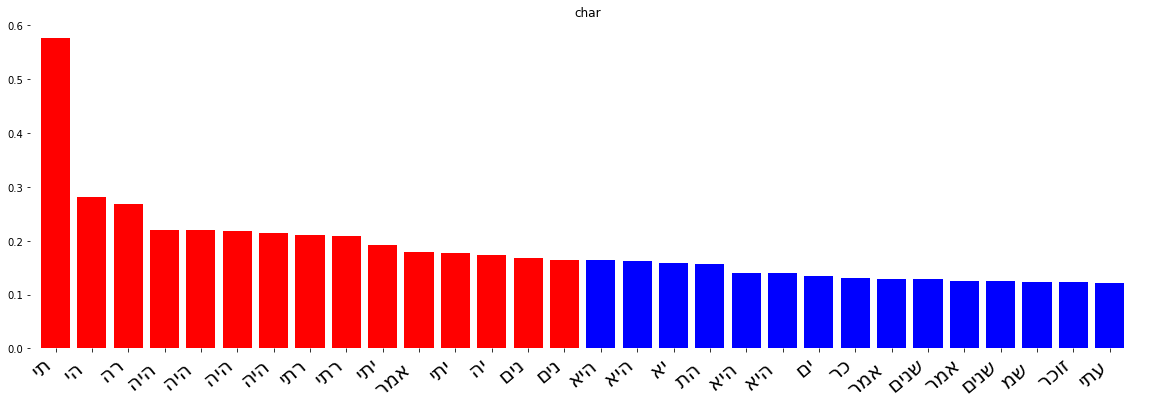

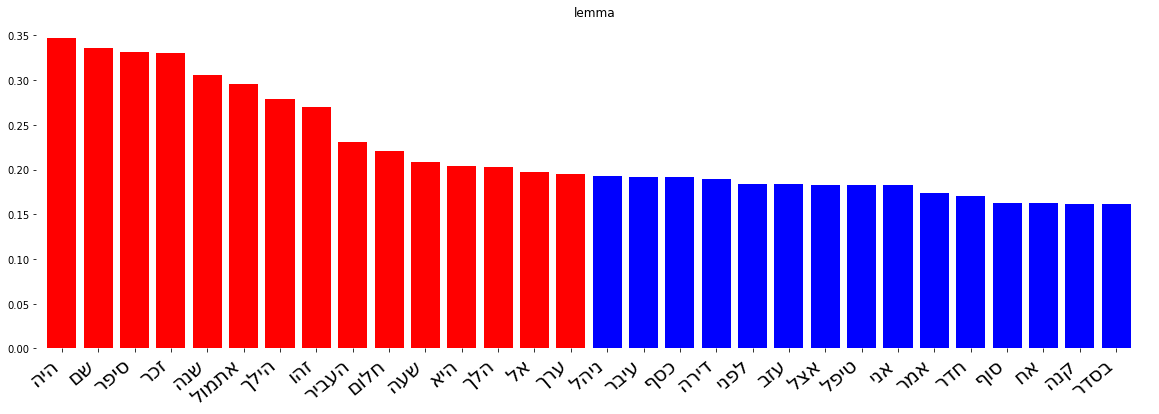

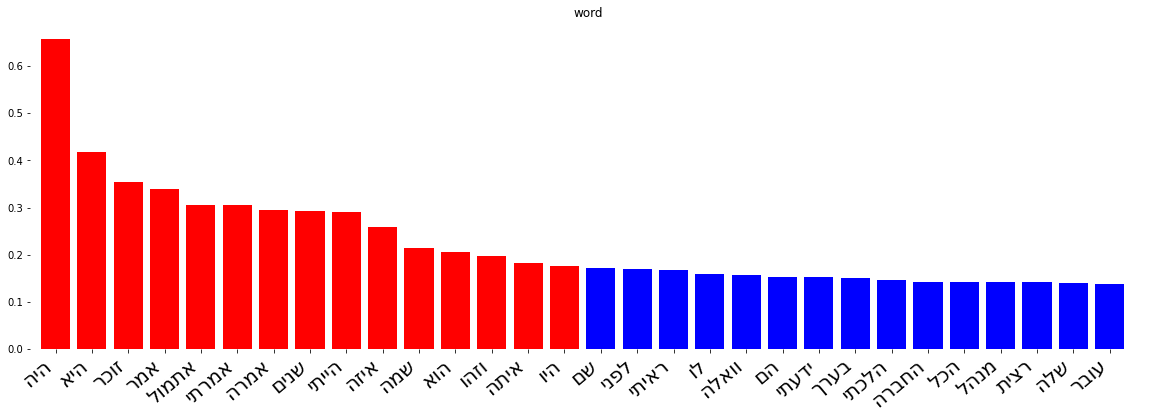

In [354]:
imp.reload(model_utils)
for tt in tf_types:
    plt.figure(figsize=(20, 6))
    ax=model_utils.plot_important_features(tt,local_plot['weight.{}.is_nar'.format(tt)].tolist(), local_plot['string.{}.is_nar'.format(tt)].tolist(), top_n=15, rotation=40)
    plt.show()

In [153]:
common_utils.save_db(local_plot,dir_name,'local.plot.tfidf.{}'.format(limit))

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/local.plot.tfidf.30.csv, 
index False
float_format %.5f


### Try different types of fixing

In [576]:
fix_options = {
    'sm.ssa':['single_miss','single_sa'],
    'dm.sm':['double_miss','single_miss'],
    'dm.sm.ssa':['double_miss,''single_miss','single_sa'],
    'sm.ssa.dm.dsa':['double_miss','single_miss','double_sa','single_sa'],
    'tm': ['tree_miss','single_sa'],
    'tm.dm.sm': ['tree_miss','double_miss','single_miss'],
    'tm.dm.sm.ssa':  ['tree_miss','double_miss','single_miss','single_sa'],
    'tm.dm.sm.one.neigh':  ['tree_miss','double_miss','single_miss'],
    'fm.tm.dm.sm.one.neigh':  ['four_miss','tree_miss','double_miss','single_miss'],
    'fm.tm.dm.sm.ssa.dsa.one.neigh':  ['four_miss','tree_miss','double_miss','single_miss','double_sa','single_sa'],
    'fm.tm.dm.sm.ssa':  ['four_miss','tree_miss','double_miss','single_miss','single_sa'],
    'sm.2':['loop_2'],
    'sm.3':['loop_3'],
    'sm.4':['loop_4'],
    'dm.shift': ['double_miss'],
    'sm.dm.shift': ['double_miss','single_miss'],
    'sm.dm.tm.shift': ['tree_miss','double_miss','single_miss'],
#     'sm.dm.tm.fm.shift': ['single_miss','double_miss','tree_miss','four_miss'],
#     'sm.dm.tm.fm.ssa': ['single_miss','double_miss','tree_miss','four_miss','single_sa'],
#     'sm.dm.tm.fm.ssa.dsa': ['single_miss','double_miss','tree_miss','four_miss','single_sa','double_sa'],
#     'order.ssa.sm.dm.tm.fm': ['single_sa','four_miss','tree_miss','double_miss','single_miss'],
    'fm.tm.dm.sm_4n': ['four_miss','tree_miss','double_miss','single_miss','single_sa'],
    'fm.tm.dm.ssa_4n.dsa_4n': ['four_miss','tree_miss','double_miss','single_miss','double_sa','single_sa']
}

In [2]:
run_options={}
run_options={
    'sm.ssa':['single_miss','single_sa'],

}

In [12]:
all_pred_crf01=common_utils.load_db(dir_name,final_name)

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/merged.crf.bert.ens.base.c.w.l.csv,  index False


In [13]:
prefixes=['base','bert','crf','ens']

In [14]:
all_pred_crf01

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,sent_idx,Unnamed: 0,...,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true,ens_par,base_predicted,base_group,base_split,base_true
0,1,0,1,0,0.45525,0.54475,0,0,0,0,...,0.84699,0.15301,1,0,0,0,0,1,7,0
1,1,0,0,0,0.76593,0.23407,1,1,1,1,...,0.84595,0.15405,1,0,0,1,0,1,7,0
2,1,0,0,0,0.79398,0.20602,2,2,2,2,...,0.84583,0.15417,1,0,0,2,0,1,7,0
3,1,0,0,0,0.59757,0.40243,3,3,3,3,...,0.84611,0.15389,1,0,0,3,0,1,7,0
4,1,0,1,0,0.40709,0.59291,4,4,4,4,...,0.84717,0.15283,1,0,0,4,0,1,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38429,79,7,0,0,0.70014,0.29986,2983,171,254,38429,...,0.84198,0.15802,79,7,0,171,0,79,0,0
38430,79,7,0,0,0.84534,0.15466,2984,172,255,38430,...,0.84326,0.15674,79,7,0,172,0,79,0,0
38431,79,7,0,0,0.85442,0.14558,2985,172,256,38431,...,0.84387,0.15613,79,7,0,172,0,79,0,0
38432,79,7,0,0,0.84201,0.15799,2986,172,257,38432,...,0.84348,0.15652,79,7,0,172,0,79,0,0


In [15]:
imp.reload(classes)
my_tables={}
for  name,opt in run_options.items():
    my_tables[name]=classes.MyScoreSummarizer(pred_df=all_pred_crf01,fix_list=opt,prefixes=prefixes)
    my_tables[name].get_all_scores(unit='split')

MyScoreSummarizer init called
MyPredFixer init called
WindowDiff init called
near misses to be fixed
 {'tot': 156, 'fp': 42, 'fn': 114}
472 middle misses to be fixed
232 stande alone to be fixed
base
bert
crf
ens
MyReport init called
MyReport init called
MyReport init called
MyReport init called


In [ ]:
my_tables[name].

In [16]:
best_fix='sm.ssa'

In [17]:
for k,v in my_tables[best_fix].print_df.items():
    print(k)
    with pd.option_context('display.float_format', '{:0.3f}'.format):
        display(v)

base


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.849,0.849,0.925,0.925,0.788,0.788
1,0.346,0.346,0.261,0.261,0.534,0.534
weighted avg,0.726,0.726,0.758,0.758,0.732,0.732


bert


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.829,0.829,0.818,0.818,0.841,0.841
1,0.517,0.517,0.539,0.539,0.500,0.500
weighted avg,0.756,0.756,0.753,0.753,0.761,0.761


crf


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.863,0.863,0.895,0.895,0.834,0.834
1,0.511,0.511,0.454,0.454,0.611,0.611
weighted avg,0.782,0.782,0.793,0.793,0.783,0.783


ens


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.878,0.880,0.932,0.930,0.830,0.837
1,0.513,0.535,0.419,0.444,0.694,0.703
weighted avg,0.792,0.800,0.809,0.815,0.800,0.806


In [20]:
for unit,val in my_tables.items():
    print('='*8+unit+'='*8)
    for k,v in val.print_df.items():
        print(k)
        with pd.option_context('display.float_format', '{:0.3f}'.format):
            display(v.drop(v.columns[v.columns.str.contains('fixed')], axis=1))
            common_utils.save_db(v.drop(v.columns[v.columns.str.contains('fixed')], axis=1),dir_name,'{}.report.as.is'.format(k))
        if k == 'ens':
            with pd.option_context('display.float_format', '{:0.3f}'.format):
                name='ens_fixed'
                print(name)
                display(v.drop(v.columns[v.columns.str.contains('sent')], axis=1))
                common_utils.save_db(v.drop(v.columns[v.columns.str.contains('sent')], axis=1),dir_name,'{}.report.as.is'.format(name))

========sm.ssa========
base


,sent_f1,sent_recall,sent_prec
0,0.849,0.925,0.788
1,0.346,0.261,0.534
weighted avg,0.726,0.758,0.732


Saving /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/base.report.as.is.csv, 
index False
float_format %.5f
bert


,sent_f1,sent_recall,sent_prec
0,0.829,0.818,0.841
1,0.517,0.539,0.500
weighted avg,0.756,0.753,0.761


Saving /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/bert.report.as.is.csv, 
index False
float_format %.5f
crf


,sent_f1,sent_recall,sent_prec
0,0.863,0.895,0.834
1,0.511,0.454,0.611
weighted avg,0.782,0.793,0.783


Saving /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.report.as.is.csv, 
index False
float_format %.5f
ens


,sent_f1,sent_recall,sent_prec
0,0.878,0.932,0.830
1,0.513,0.419,0.694
weighted avg,0.792,0.809,0.800


Saving /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.report.as.is.csv, 
index False
float_format %.5f
ens_fixed


,fixed_f1,fixed_recall,fixed_prec
0,0.880,0.930,0.837
1,0.535,0.444,0.703
weighted avg,0.800,0.815,0.806


Saving /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens_fixed.report.as.is.csv, 
index False
float_format %.5f


In [485]:
labels=val.print_df['base'].index.tolist()
labels

['0', '1', 'weighted avg']

In [395]:
val.print_df['base'].columns.tolist()

['sent_f1',
 'fixed_f1',
 'sent_recall',
 'fixed_recall',
 'sent_prec',
 'fixed_prec']

In [404]:
pure_metrics=['sent_f1','sent_recall','sent_prec']
fixed_metrics=['fixed_f1','fixed_recall','fixed_prec']

In [405]:
my_tables['sm.ssa'].print_df.keys()

dict_keys(['base', 'bert', 'crf', 'ens'])

In [421]:
th_db=pd.DataFrame()
for label in val.print_df['base'].index.tolist():
    for i,score in enumerate(pure_metrics):
        idx=th_db.shape[0]
        for model,v in my_tables['sm.ssa'].print_df.items():
            th_db.loc[idx,'label']=label
            th_db.loc[idx,'score']=score
            th_db.loc[idx,model]=v.loc[label,score]
            if model=='ens':
                th_db.loc[idx,'label']=label
                th_db.loc[idx,'score']=pure_metrics[i]
                th_db.loc[idx,'fixed']=v.loc[label,fixed_metrics[i]]
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(th_db)

,label,score,base,bert,crf,ens,fixed
0,0,sent_f1,0.849,0.829,0.863,0.878,0.880
1,0,sent_recall,0.925,0.818,0.895,0.932,0.930
2,0,sent_prec,0.788,0.841,0.834,0.830,0.837
3,1,sent_f1,0.346,0.517,0.511,0.513,0.535
4,1,sent_recall,0.261,0.539,0.454,0.419,0.444
5,1,sent_prec,0.534,0.500,0.611,0.694,0.703
6,weighted avg,sent_f1,0.726,0.756,0.782,0.792,0.800
7,weighted avg,sent_recall,0.758,0.753,0.793,0.809,0.815
8,weighted avg,sent_prec,0.732,0.761,0.783,0.800,0.806


In [425]:
th_db.set_index(['label', 'score'],inplace=True)

In [426]:
th_db

base    bert     crf     ens   fixed
label        score                                              
0            sent_f1     0.84937 0.82884 0.86312 0.87757 0.88025
             sent_recall 0.92453 0.81814 0.89540 0.93186 0.92965
             sent_prec   0.78791 0.84053 0.83425 0.83017 0.83665
1            sent_f1     0.34568 0.51715 0.51094 0.51325 0.53495
             sent_recall 0.26114 0.53862 0.45370 0.41878 0.44431
             sent_prec   0.53436 0.49990 0.61056 0.69375 0.70292
weighted avg sent_f1     0.72578 0.75609 0.78187 0.79249 0.79990
             sent_recall 0.75788 0.75282 0.79279 0.80933 0.81466
             sent_prec   0.73242 0.76111 0.78275 0.80002 0.80632

In [483]:
th_db.index

MultiIndex([(           '0',     'sent_f1'),
            (           '0', 'sent_recall'),
            (           '0',   'sent_prec'),
            (           '1',     'sent_f1'),
            (           '1', 'sent_recall'),
            (           '1',   'sent_prec'),
            ('weighted avg',     'sent_f1'),
            ('weighted avg', 'sent_recall'),
            ('weighted avg',   'sent_prec')],
           names=['label', 'score'])

In [487]:
summ_db=pd.DataFrame()
for model in th_db.columns:
    for label in labels:
        summ_db.loc[label,model]=th_db.loc[(label, 'sent_f1'),model]
summ_db

,base,bert,crf,ens,fixed
0,0.84937,0.82884,0.86312,0.87757,0.88025
1,0.34568,0.51715,0.51094,0.51325,0.53495
weighted avg,0.72578,0.75609,0.78187,0.79249,0.79990


In [488]:
common_utils.save_db(summ_db,dir_name,'sum_f1_per_model',keep_index=True)

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/sum_f1_per_model.csv, 
index True
float_format %.5f


In [471]:
th_db

base    bert     crf     ens   fixed
label        score                                              
0            sent_f1     0.84937 0.82884 0.86312 0.87757 0.88025
             sent_recall 0.92453 0.81814 0.89540 0.93186 0.92965
             sent_prec   0.78791 0.84053 0.83425 0.83017 0.83665
1            sent_f1     0.34568 0.51715 0.51094 0.51325 0.53495
             sent_recall 0.26114 0.53862 0.45370 0.41878 0.44431
             sent_prec   0.53436 0.49990 0.61056 0.69375 0.70292
weighted avg sent_f1     0.72578 0.75609 0.78187 0.79249 0.79990
             sent_recall 0.75788 0.75282 0.79279 0.80933 0.81466
             sent_prec   0.73242 0.76111 0.78275 0.80002 0.80632

In [438]:
th_db.to_csv(sep='&',line_terminator="\\ \hline \n",float_format='%.3f')

'"label"&"score"&"base"&"bert"&crf&"ens"&"fixed"\\ \\hline \n0&"sent_f1"&0.849&0.829&0.863&0.878&0.880\\ \\hline \n0&"sent_recall"&0.925&0.818&0.895&0.932&0.930\\ \\hline \n0&"sent_prec"&0.788&0.841&0.834&0.830&0.837\\ \\hline \n1&"sent_f1"&0.346&0.517&0.511&0.513&0.535\\ \\hline \n1&"sent_recall"&0.261&0.539&0.454&0.419&0.444\\ \\hline \n1&"sent_prec"&0.534&0.500&0.611&0.694&0.703\\ \\hline \n"weighted avg"&"sent_f1"&0.726&0.756&0.782&0.792&0.800\\ \\hline \n"weighted avg"&"sent_recall"&0.758&0.753&0.793&0.809&0.815\\ \\hline \n"weighted avg"&"sent_prec"&0.732&0.761&0.783&0.800&0.806\\ \\hline \n'

In [439]:
th_db.to_csv(os.getcwd()+'/dataframes/'+dir_name+'/total_res_latex.csv',sep='&',line_terminator="\\ \hline\n",float_format='%.3f')

In [414]:
total_db=pd.DataFrame()
for model,v in my_tables['sm.ssa'].print_df.items():
    for label in val.print_df['base'].index.tolist():
        idx=total_db.shape[0]
        for score in pure_metrics:
            total_db.loc[idx,'model']=model
            total_db.loc[idx,'label']=label
            total_db.loc[idx,score]=v.loc[label,score]
    if model=='ens':
        for label in val.print_df['base'].index.tolist():
            idx=total_db.shape[0]
            for i,score in enumerate(fixed_metrics):
                total_db.loc[idx,'model']='fixed'
                total_db.loc[idx,'label']=label
                total_db.loc[idx,pure_metrics[i]]=v.loc[label,score]
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(total_db)

,model,label,sent_f1,sent_recall,sent_prec
0,base,0,0.849,0.925,0.788
1,base,1,0.346,0.261,0.534
2,base,weighted avg,0.726,0.758,0.732
3,bert,0,0.829,0.818,0.841
4,bert,1,0.517,0.539,0.500
5,bert,weighted avg,0.756,0.753,0.761
6,crf,0,0.863,0.895,0.834
7,crf,1,0.511,0.454,0.611
8,crf,weighted avg,0.782,0.793,0.783
9,ens,0,0.878,0.932,0.830


In [ ]:
total_db=pd.DataFrame()
for model,v in my_tables['sm.ssa'].print_df.items():
    for label in val.print_df['base'].index.tolist():
        idx=total_db.shape[0]
        for score in pure_metrics:
            total_db.loc[idx,'model']=model
            total_db.loc[idx,'label']=label
            total_db.loc[idx,score]=v.loc[label,score]
    if model=='ens':
        for label in val.print_df['base'].index.tolist():
            idx=total_db.shape[0]
            for i,score in enumerate(fixed_metrics):
                total_db.loc[idx,'model']='fixed'
                total_db.loc[idx,'label']=label
                total_db.loc[idx,pure_metrics[i]]=v.loc[label,score]
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(total_db)

In [415]:
plain_db=pd.DataFrame()
for model,v in my_tables['sm.ssa'].print_df.items():
    for label in val.print_df['base'].index.tolist():
        for score in pure_metrics:
            idx=plain_db.shape[0]
            plain_db.loc[idx,'model']=model
            plain_db.loc[idx,'label']=label
            plain_db.loc[idx,'score']=score
            plain_db.loc[idx,'val']=v.loc[label,score]
    if model=='ens':
        for label in val.print_df['base'].index.tolist():
            idx=plain_db.shape[0]
            for i,score in enumerate(fixed_metrics):
                plain_db.loc[idx,'model']='fixed'
                plain_db.loc[idx,'label']=label
                plain_db.loc[idx,'score']=pure_metrics[i]
                plain_db.loc[idx,'val']=v.loc[label,score]
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(plain_db)

,model,label,score,val
0,base,0,sent_f1,0.849
1,base,0,sent_recall,0.925
2,base,0,sent_prec,0.788
3,base,1,sent_f1,0.346
4,base,1,sent_recall,0.261
5,base,1,sent_prec,0.534
6,base,weighted avg,sent_f1,0.726
7,base,weighted avg,sent_recall,0.758
8,base,weighted avg,sent_prec,0.732
9,bert,0,sent_f1,0.829


In [428]:
common_utils.save_db(th_db,dir_name,'total_res_db_thesis_multi.idx',keep_index=True,float_format='%.3f')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/total_res_db_thesis_multi.idx.csv, 
index True
float_format %.3f


In [412]:
total_db.transpose()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
model,base,base,base,base,base,base,base,base,base,bert,...,ens,ens,ens,ens,ens,ens,ens,fixed,fixed,fixed
label,0,0,0,1,1,1,weighted avg,weighted avg,weighted avg,0,...,0,1,1,1,weighted avg,weighted avg,weighted avg,0,1,weighted avg
score,sent_f1,sent_recall,sent_prec,sent_f1,sent_recall,sent_prec,sent_f1,sent_recall,sent_prec,sent_f1,...,sent_prec,sent_f1,sent_recall,sent_prec,sent_f1,sent_recall,sent_prec,sent_prec,sent_prec,sent_prec
val,0.84937,0.92453,0.78791,0.34568,0.26114,0.53436,0.72578,0.75788,0.73242,0.82884,...,0.83017,0.51325,0.41878,0.69375,0.79249,0.80933,0.80002,0.83665,0.70292,0.80632


In [418]:
plain_db.groupby(['label','score']).reset_index()

AttributeError: 'SeriesGroupBy' object has no attribute 'reset_index'

# Get score per different unit

In [271]:
imp.reload(classes)
my_tables={}
for name in ['split','group','all']:
    my_tables[name]=classes.MyScoreSummarizer(pred_df=all_pred_crf01,fix_list=run_options['sm.ssa'])
    my_tables[name].get_all_scores(unit=name)

MyScoreSummarizer init called
MyPredFixer init called
WindowDiff init called
ens
near misses to be fixed
 {'tot': 173, 'fp': 59, 'fn': 114}
524 middle misses to be fixed
225 stande alone to be fixed
MyReport init called
MyReport init called
MyReport init called
MyScoreSummarizer init called
MyPredFixer init called
WindowDiff init called
ens
near misses to be fixed
 {'tot': 173, 'fp': 59, 'fn': 114}
524 middle misses to be fixed
225 stande alone to be fixed
MyReport init called


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

MyReport init called


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

MyReport init called
MyScoreSummarizer init called
MyPredFixer init called
WindowDiff init called
ens
near misses to be fixed
 {'tot': 173, 'fp': 59, 'fn': 114}
524 middle misses to be fixed
225 stande alone to be fixed
MyReport init called
MyReport init called
MyReport init called


In [278]:
common_utils.save_db(my_tables['split'].print_df['crf'],dir_name,'crf.split.report.with.lemma')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.split.report.with.lemma.csv, 
index False
float_format %.5f


In [317]:
imp.reload(common_utils)
crf_report_no_lemma=common_utils.load_db(dir_name,'crf.split.report.no.lemma','label')

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.split.report.no.lemma.csv,  index label


In [326]:
my_tables['split'].print_df['crf'].index.name='label'

In [327]:
my_tables['split'].print_df['crf']

,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
label,,,,,,
0,0.86087,0.86087,0.89050,0.89050,0.83421,0.83421
1,0.51531,0.51531,0.46164,0.46164,0.59763,0.59763
weighted avg,0.78050,0.78050,0.78993,0.78993,0.77985,0.77985


In [319]:
crf_report_no_lemma#.loc[0,'sent_f1']

,sent_f1,sent_recall,sent_prec
label,,,
0,0.86100,0.89100,0.83400
1,0.51100,0.45900,0.58600
weighted avg,0.78000,0.78900,0.77800


In [329]:
crf_report_no_lemma.index

Index(['0', '1', 'weighted avg'], dtype='object', name='label')

In [320]:
crf_report_no_lemma.loc[i,col]

0.78

In [351]:
compare=pd.DataFrame()
for label in crf_report_no_lemma.index:
    for col in ['sent_f1','sent_recall','sent_prec']:
        idx=len(compare.index)
        compare.loc[idx,'label']=label
        compare.loc[idx,'feature']=col
        compare.loc[idx,'val']=my_tables['split'].print_df['crf'].loc[label,col]
        compare.loc[idx,'lemma']='use'
        compare.loc[idx,'feature']=col

        compare.loc[idx+1,'label']=label
        compare.loc[idx+1,'feature']=col
        compare.loc[idx+1,'val']=crf_report_no_lemma.loc[label,col]
        compare.loc[idx+1,'lemma']='no_use'


compare


,label,feature,val,lemma
0,0,sent_f1,0.86087,use
1,0,sent_f1,0.86100,no_use
2,0,sent_recall,0.89050,use
3,0,sent_recall,0.89100,no_use
4,0,sent_prec,0.83421,use
5,0,sent_prec,0.83400,no_use
6,1,sent_f1,0.51531,use
7,1,sent_f1,0.51100,no_use
8,1,sent_recall,0.46164,use
9,1,sent_recall,0.45900,no_use


In [378]:
common_utils.save_db(compare,dir_name,'crf.per.client.scores.with.without.lemma')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.per.client.scores.with.without.lemma.csv, 
index False
float_format %.5f


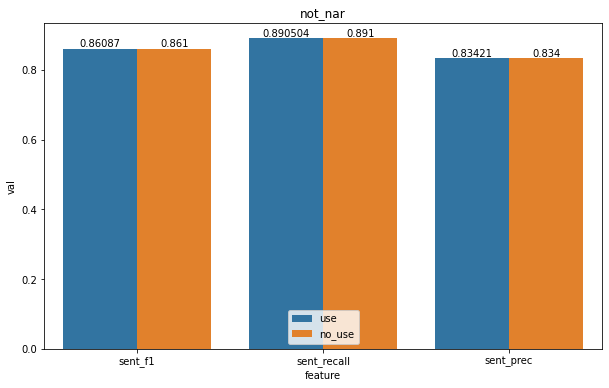

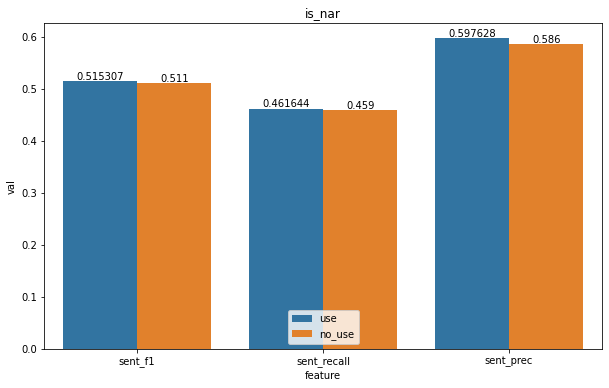

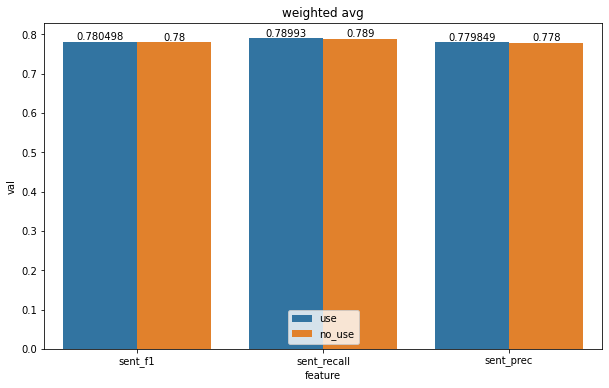

In [379]:
df=compare
ax={}
for l in df.label.unique():
    plt.figure(figsize=(10, 6))
    ax[l]= sns.barplot(x='feature',y='val',hue='lemma', data=df[df['label']==l],errwidth=0)
 

    for container in ax[l].containers:
        ax[l].bar_label(container)
    title = 'is_nar' if l == '1' else 'not_nar' if l == '0' else l
    ax[l].set_title(title)
    plt.legend(loc='lower center')
    plt.show()

In [368]:
unit_compare=pd.DataFrame()
for unit,val in my_tables.items():
    print('='*8+unit+'='*8)
    for k,v in val.print_df.items():
        print('{} {:.3f}'.format(k,v.loc['weighted avg','sent_f1']))
        unit_compare.loc[k,unit]=v.loc['weighted avg','sent_f1']
        if k == 'ens':
            print('fixed {} {:.3f}'.format(k,v.loc['weighted avg','fixed_f1']))
            unit_compare.loc['fixed_{}'.format(k),unit]=v.loc['weighted avg','fixed_f1']
unit_compare.rename({'group':'doc'},axis=1,inplace=True)
unit_compare.index.name='model'

========split========
bert 0.756
crf 0.780
ens 0.793
fixed ens 0.801
========group========
bert 0.760
crf 0.777
ens 0.791
fixed ens 0.799
========all========
bert 0.745
crf 0.778
ens 0.788
fixed ens 0.796


In [ ]:
unit_compare.

In [370]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(unit_compare)

,split,doc,all
model,,,
bert,0.756,0.760,0.745
crf,0.780,0.777,0.778
ens,0.793,0.791,0.788
fixed_ens,0.801,0.799,0.796


In [39]:
compare_fixes=pd.DataFrame()
for k,v in my_tables.items():
#     for col in v.print_df['ens'].columns:
#         if 'par' in col:
#             v.print_df['ens'].drop(col,inplace=True, axis=1)
#     if v.print_df['ens'].loc['weighted avg','fixed_f1']>=0.806:
# #     print(k,fix_options[k])
#     with pd.option_context('display.float_format', '{:0.3f}'.format):
#         display(v.print_df['ens'])
# # #         common_utils.save_db(v.print_df['ens'],dir_name,'fixed.f1.{}'.format(k))
    for c in v.print_df['ens'][['fixed_f1','fixed_recall','fixed_prec']]: #[['fixed_f1','fixed_recall','fixed_precision']]:
        for l in v.print_df['ens'].index:
            compare_fixes.loc[k,'{}_{}'.format(l,c)]=v.print_df['ens'].loc[l,c]
# compare_fixes.sort_values(by='weighted avg_fixed_f1')

In [40]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(compare_fixes)

,0_fixed_f1,1_fixed_f1,weighted avg_fixed_f1,0_fixed_recall,1_fixed_recall,weighted avg_fixed_recall,0_fixed_prec,1_fixed_prec,weighted avg_fixed_prec
sm.ssa,0.879,0.550,0.801,0.922,0.468,0.813,0.840,0.678,0.803


In [41]:
fixes=['weighted avg_fixed_f1','1_fixed_recall']
# fixes=['1_fixed_recall']
compare_fixes.sort_values(by=fixes,ascending=False).head()

,0_fixed_f1,1_fixed_f1,weighted avg_fixed_f1,0_fixed_recall,1_fixed_recall,weighted avg_fixed_recall,0_fixed_prec,1_fixed_prec,weighted avg_fixed_prec
sm.ssa,0.87861,0.54959,0.80136,0.92173,0.46817,0.81347,0.83990,0.67831,0.80328


In [42]:
compare_fixes[(compare_fixes['1_fixed_recall']>0.5)&(compare_fixes['weighted avg_fixed_f1']>=0.801)]

,0_fixed_f1,1_fixed_f1,weighted avg_fixed_f1,0_fixed_recall,1_fixed_recall,weighted avg_fixed_recall,0_fixed_prec,1_fixed_prec,weighted avg_fixed_prec


<AxesSubplot:>

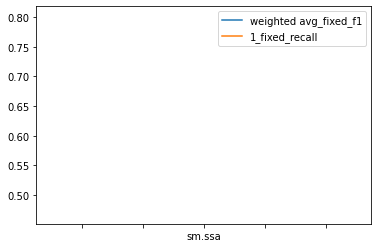

In [43]:
compare_fixes[['weighted avg_fixed_f1','1_fixed_recall']].head().plot()

In [44]:
best_fix=compare_fixes['1_fixed_recall'].idxmax()
# best_fix='tm.dm.sm.one.neigh'
best_fix='sm.ssa'

In [45]:
compare_fixes.loc[best_fix,:]

0_fixed_f1                  0.87861
1_fixed_f1                  0.54959
weighted avg_fixed_f1       0.80136
0_fixed_recall              0.92173
1_fixed_recall              0.46817
weighted avg_fixed_recall   0.81347
0_fixed_prec                0.83990
1_fixed_prec                0.67831
weighted avg_fixed_prec     0.80328
Name: sm.ssa, dtype: float64

In [46]:
my_tables[best_fix].my_fixer.fixed_df

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,...,crf_proba_0,crf_proba_1,crf_sent_idx,ens_par_x,ens_predicted,ens_group,ens_split,ens_true,ens_par_y,ens_sent_idx
0,1,0,1,0,0.45525,0.54475,0,0,1,0,...,0.96872,0.03128,0,0,0,1,0,0,0,0
1,1,0,0,0,0.76593,0.23407,1,1,1,1,...,0.98367,0.01633,1,1,0,1,0,0,1,1
2,1,0,0,0,0.79398,0.20602,2,2,1,2,...,0.99680,0.00320,2,2,0,1,0,0,2,2
3,1,0,0,0,0.59757,0.40243,3,3,1,3,...,0.98790,0.01210,3,3,0,1,0,0,3,3
4,1,0,1,0,0.40709,0.59291,4,4,1,4,...,0.98713,0.01287,4,4,0,1,0,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38429,79,7,0,0,0.70014,0.29986,254,171,79,171,...,0.97277,0.02723,254,171,0,79,7,0,171,254
38430,79,7,0,0,0.84534,0.15466,255,172,79,172,...,0.89664,0.10336,255,172,0,79,7,0,172,255
38431,79,7,0,0,0.85442,0.14558,256,172,79,172,...,0.91198,0.08802,256,172,0,79,7,0,172,256
38432,79,7,0,0,0.84201,0.15799,257,172,79,172,...,0.92254,0.07746,257,172,0,79,7,0,172,257


In [47]:
common_utils.save_db(my_tables[best_fix].my_fixer.fixed_df,dir_name,'fixed_pred_{}.per.client'.format(best_fix))

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/fixed_pred_sm.ssa.per.client.csv, 
index False
float_format %.5f


In [586]:
my_tables[best_fix].my_fixer.stat

{'base': {'total_fp': 2238,
  'total_fn': 7403,
  'near': {'tot': 264, 'fp': 76, 'fn': 188},
  'mid': 607,
  'mid_orig': 362,
  'stand_alone': 1155,
  'stand_alone_orig': 798},
 'bert': {'total_fp': 5434,
  'total_fn': 4494,
  'near': {'tot': 336, 'fp': 163, 'fn': 173},
  'mid': 1860,
  'mid_orig': 915,
  'stand_alone': 691,
  'stand_alone_orig': 614},
 'crf': {'total_fp': 3117,
  'total_fn': 4983,
  'near': {'tot': 50, 'fp': 27, 'fn': 23},
  'mid': 2,
  'mid_orig': 2,
  'stand_alone': 6,
  'stand_alone_orig': 3},
 'ens': {'near': {'tot': 156, 'fp': 42, 'fn': 114},
  'mid': 472,
  'mid_orig': 318,
  'stand_alone': 232,
  'stand_alone_orig': 138,
  'total_fp': 2077,
  'total_fn': 5432}}

In [591]:
dd=pd.DataFrame(my_tables[best_fix].my_fixer.stat)
dd

,base,bert,crf,ens
total_fp,2238,5434,3117,2077
total_fn,7403,4494,4983,5432
near,"{'tot': 264, 'fp': 76, 'fn': 188}","{'tot': 336, 'fp': 163, 'fn': 173}","{'tot': 50, 'fp': 27, 'fn': 23}","{'tot': 156, 'fp': 42, 'fn': 114}"
mid,607,1860,2,472
mid_orig,362,915,2,318
stand_alone,1155,691,6,232
stand_alone_orig,798,614,3,138


### Get stat on best fixes

In [592]:
fix_options[best_fix]

['single_miss', 'single_sa']

In [604]:
imp.reload(classes)
best_fix_stat=classes.MyScoreSummarizer(pred_df=all_pred_crf01,fix_list=fix_options[best_fix],prefixes=prefixes)
best_fix_stat.get_all_scores()

MyScoreSummarizer init called
MyPredFixer init called
WindowDiff init called
near misses to be fixed
 {'tot': 156, 'fp': 42, 'fn': 114}
472 middle misses to be fixed
232 stande alone to be fixed
base
bert
crf
ens
MyReport init called
MyReport init called
MyReport init called
MyReport init called


In [607]:
stat_df=pd.DataFrame(best_fix_stat.my_fixer.stat)
stat_df

,base,bert,crf,ens
total_fp,2238,5434,3117,2077
total_fn,7403,4494,4983,5432
near,"{'tot': 264, 'fp': 76, 'fn': 188}","{'tot': 336, 'fp': 163, 'fn': 173}","{'tot': 50, 'fp': 27, 'fn': 23}","{'tot': 156, 'fp': 42, 'fn': 114}"
mid,607,1860,2,472
mid_orig,362,915,2,318
stand_alone,1155,691,6,232
stand_alone_orig,798,614,3,138
unique,NaN,5743,3915,NaN
false_neg_unique,NaN,1659,2148,NaN
false_pos_unique,NaN,4084,1767,NaN


In [690]:
common_utils.save_db(stat_df,dir_name,'stat_db')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/stat_db.csv, 
index False
float_format %.5f


In [ ]:
estimator     nm mm  rest
BERT   170	1472	2876
CRF    51	31	4701	
ensemble 96	290	4502

In [699]:
stack_fn=pd.DataFrame()
for model in ['bert','crf','ens']:
    stack_fn.loc[model,'nm']=stat_df.loc['near',model]['fp']
    stack_fn.loc[model,'mm']=stat_df.loc['mid_orig',model]
    stack_fn.loc[model,'rest']=stat_df.loc['total_fn',model]-stack_fn.loc[model,'mm']-stack_fn.loc[model,'nm']

In [700]:
stack_fn

,nm,mm,rest
bert,163.00000,915.00000,3416.00000
crf,27.00000,2.00000,4954.00000
ens,42.00000,318.00000,5072.00000


In [703]:
stack_fp=pd.DataFrame()
for model in ['bert','crf','ens']:
    stack_fp.loc[model,'nm']=stat_df.loc['near',model]['fp']
    stack_fp.loc[model,'sa']=stat_df.loc['stand_alone_orig',model]
    stack_fp.loc[model,'rest']=stat_df.loc['total_fp',model]-stack_fp.loc[model,'sa']-stack_fp.loc[model,'nm']
stack_fp

,nm,sa,rest
bert,163.00000,614.00000,4657.00000
crf,27.00000,3.00000,3087.00000
ens,42.00000,138.00000,1897.00000


In [711]:
stack_fp['sum']=stack_fp.agg(sum)

In [713]:
stack_fp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, bert to ens
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   nm      3 non-null      float64
 1   sa      3 non-null      float64
 2   rest    3 non-null      float64
 3   sum     0 non-null      float64
dtypes: float64(4)
memory usage: 228.0+ bytes


In [621]:
for t in ['crf','bert']:
    print(t)
    print(stat_df.loc['unique',t]/(stat_df.loc['total_fn',t]+stat_df.loc['total_fp',t]))

crf
0.48333333333333334
bert
0.5784649476228848


In [ ]:
stat_df.loc['false_neg_unique','crf']/stat_df.loc['total_fn','crf']

In [691]:
common_utils.save_db(stat_df.iloc[:2,1:].transpose(),dir_name,'error.rate.all')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/error.rate.all.csv, 
index False
float_format %.5f


In [617]:
for t in ['pos','neg']:
    print("\n "+t)
    print(stat_df.loc['false_{}_unique'.format(t)][['crf','bert']])
    
    print(stat_df.loc['common_{}'.format(t),'crf'])


 pos
crf     1767
bert    4084
Name: false_pos_unique, dtype: object
1350

 neg
crf     2148
bert    1659
Name: false_neg_unique, dtype: object
2835


In [597]:
for a,b in best_fix_stat.my_fixer.stat.items():
    for c,d in b.items():
         print(a,'\t',c,'\t\t\t',d)

base 	 total_fp 			 2238
base 	 total_fn 			 7403
base 	 near 			 {'tot': 264, 'fp': 76, 'fn': 188}
base 	 mid 			 607
base 	 mid_orig 			 362
base 	 stand_alone 			 1155
base 	 stand_alone_orig 			 798
bert 	 total_fp 			 5434
bert 	 total_fn 			 4494
bert 	 near 			 {'tot': 336, 'fp': 163, 'fn': 173}
bert 	 mid 			 1860
bert 	 mid_orig 			 915
bert 	 stand_alone 			 691
bert 	 stand_alone_orig 			 614
crf 	 total_fp 			 3117
crf 	 total_fn 			 4983
crf 	 near 			 {'tot': 50, 'fp': 27, 'fn': 23}
crf 	 mid 			 2
crf 	 mid_orig 			 2
crf 	 stand_alone 			 6
crf 	 stand_alone_orig 			 3
ens 	 near 			 {'tot': 156, 'fp': 42, 'fn': 114}
ens 	 mid 			 472
ens 	 mid_orig 			 318
ens 	 stand_alone 			 232
ens 	 stand_alone_orig 			 138
ens 	 total_fp 			 2077
ens 	 total_fn 			 5432


## get boundaries for fixd fm,tm,dm,sm


In [162]:
doc_to_use=4
t=best_fix

In [163]:
common_utils.save_db(my_tables[t].my_fixer.fixed_df,dir_name,'pred.fixed.per_client_{}'.format(t))

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/pred.fixed.per_client_sm.ssa.csv, 
index False
float_format %.5f


In [165]:
wd = classes.WindowDiff()
start={}
end={}
est='ens'

my_pred=my_tables[t].my_fixer.fixed_df.copy()


est_gr='{}_group'.format(est)
est_pred='{}_predicted'.format(est)
start[t], end[t] = wd.get_boundaries_indices(my_pred.loc[my_pred[est_gr]==doc_to_use,est_pred].tolist())
bound_db={}
bound_db[t]=pd.DataFrame()
bound_db[t]['start']=start[t]
bound_db[t]['end']=end[t]
print(t,bound_db[t])
common_utils.save_db(bound_db[t],dir_name,'boundary_{}_fixed'.format(doc_to_use))

WindowDiff init called
sm.ssa    start  end
0     45   60
1     67   77
2     87   95
3     97  105
4    180  182
5    225  227
6    280  285
7    403  405
Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/boundary_4_fixed.csv, 
index False
float_format %.5f


In [23]:
my_end=common_utils.load_db(dir_name,'all_pred.threshold0.256')
my_ens_fixed=common_utils.load_db(dir_name,'all_pred_fixed.threshold0.256')

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/all_pred.threshold0.256.csv,  index False
Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/all_pred_fixed.threshold0.256.csv,  index False


In [26]:
# my_pred=my_tables[t].my_fixer.orig_df.copy()
# for est in ['crf','bert','ens']:
imp.reload(classes)
wd = classes.WindowDiff()
est='ens'
doc_to_use=4
est_gr='{}_group'.format(est)
est_pred='{}_predicted'.format(est)
# for db in [my_end,my_ens_fixed]:
ens = wd.get_boundaries_db(my_end.loc[my_pred[est_gr]==doc_to_use,est_pred].tolist())
common_utils.save_db(ens,dir_name,'boundary_{}_{}'.format(est,doc_to_use))
ens_fix = wd.get_boundaries_db(my_ens_fixed.loc[my_pred[est_gr]==doc_to_use,est_pred].tolist())
est='ens_fix'
common_utils.save_db(ens_fix,dir_name,'boundary_{}_{}'.format(est,doc_to_use))

WindowDiff init called
Saving /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/boundary_ens_4.csv, 
index False
float_format %.5f
Saving /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/boundary_ens_fix_4.csv, 
index False
float_format %.5f


## Get baseline model boundary

In [386]:
baseline_pred=common_utils.load_db(dir_name,'Ridge.pred_all')

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/Ridge.pred_all.csv,  index False


In [394]:
baseline_pred['all_predicted']=baseline_pred['all_predicted'].astype(int)

In [399]:
base_pred=baseline_pred.loc[baseline_pred[est_gr]==doc_to_use,est_pred].tolist()
st,end=wd.get_boundaries_indices(base_pred)

In [400]:
len(st),len(end)

(33, 33)

In [404]:
est='all'
est_gr='{}_group'.format(est)
est_pred='{}_predicted'.format(est)
base_pred=baseline_pred.loc[baseline_pred[est_gr]==doc_to_use,est_pred].tolist()
st,end=wd.get_boundaries_indices(base_pred)
bound_db[est]=pd.DataFrame()
bound_db[est]['start']=st
bound_db[est]['end']=end
print(t,bound_db[est])
common_utils.save_db(bound_db[est],dir_name,'boundary_baseline_{}'.format(doc_to_use))


tm.dm.sm.ssa     start  end
0       5    7
1      18   22
2      39   40
3      48   49
4      52   55
5      56   57
6      58   59
7      69   74
8      75   76
9      87   88
10     89   90
11     91   92
12     93   94
13     99  103
14    104  105
15    108  109
16    142  143
17    151  152
18    159  160
19    161  162
20    177  178
21    180  181
22    197  198
23    199  200
24    207  208
25    216  217
26    224  225
27    280  282
28    283  284
29    286  287
30    288  290
31    404  405
32    409  410
Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/boundary_baseline_4.csv, 
index False
float_format %.5f


In [385]:
print(bound_db['ens'])

    start  end
0       5   15
1      18   20
2      45   60
3      65  105
4     176  179
5     180  184
6     195  210
7     225  227
8     231  234
9     237  238
10    239  240
11    241  242
12    279  286
13    390  391
14    392  393
15    394  398
16    400  405


In [311]:
est_gr,doc_to_use

('ens_group', 4)

In [312]:
my_tables[t].my_fixer.fixed_df.query('ens_group==4')

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,...,crf_proba_0,crf_proba_1,crf_sent_idx,ens_par_x,ens_predicted,ens_group,ens_split,ens_true,ens_par_y,ens_sent_idx
0,4,0,0,0,0.71091,0.28909,0,0,4,0,...,0.94762,0.05238,0,0,0,4,0,0,0,0
1,4,0,0,0,0.76246,0.23754,1,1,4,1,...,0.95654,0.04346,1,1,0,4,0,0,1,1
2,4,0,0,0,0.81931,0.18069,2,2,4,2,...,0.96496,0.03504,2,2,0,4,0,0,2,2
3,4,0,0,0,0.52200,0.47800,3,3,4,3,...,0.83787,0.16213,3,3,0,4,0,0,3,3
4,4,0,0,0,0.68196,0.31804,4,3,4,3,...,0.69050,0.30950,4,3,0,4,0,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,4,0,0,0,0.74785,0.25215,466,128,4,128,...,0.98562,0.01438,466,128,0,4,0,0,128,466
467,4,0,0,0,0.79953,0.20047,467,128,4,128,...,0.99452,0.00548,467,128,0,4,0,0,128,467
468,4,0,0,0,0.78473,0.21527,468,129,4,129,...,0.99627,0.00373,468,129,0,4,0,0,129,468
469,4,0,0,0,0.77627,0.22373,469,130,4,130,...,0.99655,0.00345,469,130,0,4,0,0,130,469


### Extra narratives

In [ ]:
my_tables[t].my_fixer.fixed_df['ens_pred'].

### Get unique mistakes

In [568]:
my_tables[t].my_fixer.pred_db

KeyError: 'ens'

In [168]:
types={'bert':0,'crf':0}
pos_label=1
mistakes={}
for t in types.keys():
    mistakes[t]={}
    l=types[t]
    mistakes[t]['total_index']=set(my_tables[best_fix].my_fixer.pred_df.query('{}_predicted!={}_true'.format(t,t)).index)
    mistakes[t]['false_neg_index']=set(my_tables[best_fix].my_fixer.pred_df.query('{}_predicted!={}_true and {}_predicted==@l'.format(t,t,t)).index)
    mistakes[t]['false_pos_index']=set(my_tables[best_fix].my_fixer.pred_df.query('{}_predicted!={}_true and {}_predicted==@pos_label'.format(t,t,t)).index)
    mistakes[t]['total_count']=len(mistakes[t]['total_index'])
    mistakes[t]['false_neg_count']=len(mistakes[t]['false_neg_index'])
    mistakes[t]['false_pos_count']=len(mistakes[t]['false_pos_index'])


In [169]:
mistakes['bert']['unique']=mistakes['bert']['total_index']-mistakes['crf']['total_index']
mistakes['crf']['unique']=mistakes['crf']['total_index']-mistakes['bert']['total_index']

mistakes['bert']['false_neg_unique']=mistakes['bert']['false_neg_index']-mistakes['crf']['false_neg_index']
mistakes['crf']['false_neg_unique']=mistakes['crf']['false_neg_index']-mistakes['bert']['false_neg_index']

mistakes['bert']['false_pos_unique']=mistakes['bert']['false_pos_index']-mistakes['crf']['false_pos_index']
mistakes['crf']['false_pos_unique']=mistakes['crf']['false_pos_index']-mistakes['bert']['false_pos_index']

for t in types:
    mistakes[t]['unique_count']=len(mistakes[t]['unique'])
    mistakes[t]['unique_ratio']=mistakes[t]['unique_count']/mistakes[t]['total_count']
    print("Unique mistakes of {} {}".format(t,mistakes[t]['unique_ratio']))

Unique mistakes of bert 0.5784649476228848
Unique mistakes of crf 0.48333333333333334


In [170]:
for k,v in mistakes.items():
    for i,j in v.items():
        if isinstance(j,set):
            print(k,i,len(j))
        else:
            print(k,i,j)

bert total_index 9928
bert false_neg_index 4494
bert false_pos_index 5434
bert total_count 9928
bert false_neg_count 4494
bert false_pos_count 5434
bert unique 5743
bert false_neg_unique 4494
bert false_pos_unique 5434
bert unique_count 5743
bert unique_ratio 0.5784649476228848
crf total_index 8100
crf false_neg_index 0
crf false_pos_index 0
crf total_count 8100
crf false_neg_count 0
crf false_pos_count 0
crf unique 3915
crf false_neg_unique 0
crf false_pos_unique 0
crf unique_count 3915
crf unique_ratio 0.48333333333333334


In [171]:
err_stat_db=pd.DataFrame()
for est_name,est_stat in my_tables[best_fix].my_fixer.stat.items():
    for stat_type,stat_val in est_stat.items():
        if stat_type=='near':
            for near_name,near_val in stat_val.items():
                err_stat_db.loc["{}_{}".format(stat_type,near_name),est_name]=near_val
        else:
            err_stat_db.loc["{}".format(stat_type),est_name]=stat_val
#             if stat_type in ['mid','stand_alone']:
#                 err_stat_db.loc["{}_rate".format(stat_type),est_name]=stat_val*100/estimator['total_fp']
#             if 'total' in err_type:
#                 err_stat_db.loc["{}_rate".format(stat_type),est_name]=stat_val*100/(estimator['total_fp']+estimator['total_fn'])
err_stat_db

,ens
near_tot,156.00000
near_fp,42.00000
near_fn,114.00000
mid,472.00000
mid_orig,318.00000
stand_alone,232.00000
stand_alone_orig,138.00000
total_fp,2077.00000
total_fn,5432.00000


In [172]:
my_tables[best_fix].get_all_scores()

MyReport init called
MyReport init called
MyReport init called


In [173]:
for k,v in my_tables[best_fix].print_df.items():
#     if k!='ens':
#         print(k)
#     #     for col in v.columns:
#     #         if 'par' in col:
#     #             v.drop(col,inplace=True, axis=1)
#         with pd.option_context('display.float_format', '{:0.3f}'.format):
#             display(v)
#     else:
    print(k)
#     print('ens pure')
    with pd.option_context('display.float_format', '{:0.3f}'.format):

        display(v.drop(v.columns[v.columns.str.contains('fixed')], axis=1))
    if k == 'ens':
        with pd.option_context('display.float_format', '{:0.3f}'.format):

            print('ens fixed')
            display(v.drop(v.columns[v.columns.str.contains('sent')], axis=1))

bert


,sent_f1,sent_recall,sent_prec
0,0.829,0.818,0.841
1,0.517,0.539,0.500
weighted avg,0.756,0.753,0.761


crf


,sent_f1,sent_recall,sent_prec
not_nar,0.863,0.895,0.834
is_nar,0.511,0.454,0.611
weighted avg,0.782,0.793,0.783


ens


,sent_f1,sent_recall,sent_prec
0,0.878,0.932,0.830
1,0.513,0.419,0.694
weighted avg,0.792,0.809,0.800


ens fixed


,fixed_f1,fixed_recall,fixed_prec
0,0.880,0.930,0.837
1,0.535,0.444,0.703
weighted avg,0.800,0.815,0.806


### Plot precision recall curve

In [381]:
all_pred_crf01['crf_true']

0        not_nar
1        not_nar
2        not_nar
3        not_nar
4        not_nar
          ...   
38429    not_nar
38430    not_nar
38431    not_nar
38432    not_nar
38433    not_nar
Name: crf_true, Length: 38434, dtype: object

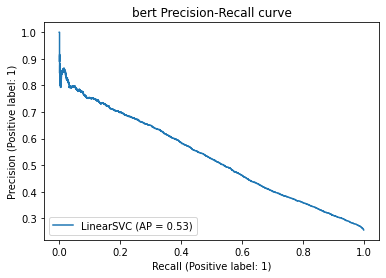

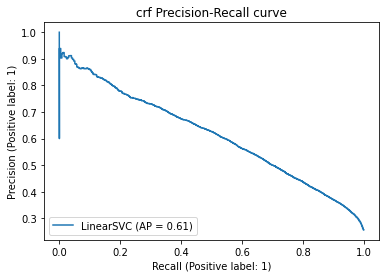

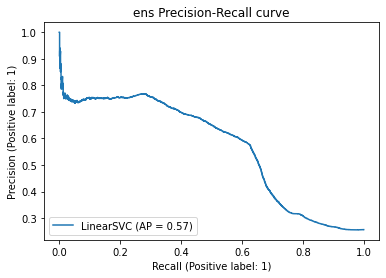

In [387]:
from sklearn.metrics import PrecisionRecallDisplay

for t in ['bert','crf','ens']:
    y_test=all_pred_crf01['{}_true'.format(t)].tolist()
    y_score=all_pred_crf01['{}_proba_1'.format(t)].tolist()

    display_ = PrecisionRecallDisplay.from_predictions(y_test, y_score, name="LinearSVC")
    _ = display_.ax_.set_title("{} Precision-Recall curve".format(t))

Best Threshold=0.389610, G-Mean=0.677


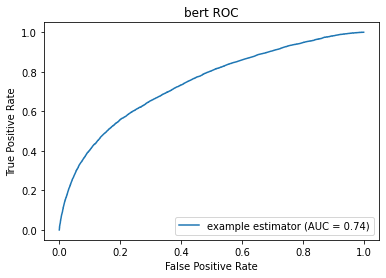

Best Threshold=0.203000, G-Mean=0.730


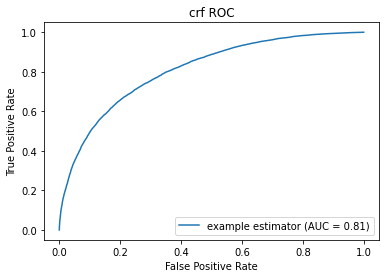

Best Threshold=0.159640, G-Mean=0.726


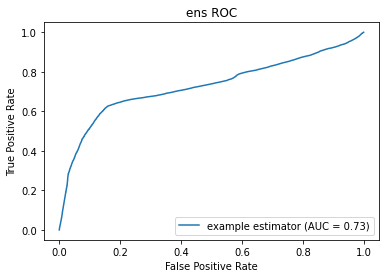

In [388]:
from sklearn import metrics
for t in ['bert','crf','ens']:
#     print(">"*8+t+">"*8)
    y_test=all_pred_crf01['{}_true'.format(t)].tolist()
    y_score=all_pred_crf01['{}_proba_1'.format(t)].tolist()
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    display_ = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                       estimator_name='example estimator')
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    display_.plot()
    plt.title('{} ROC'.format(t))
    plt.show()

In [276]:

print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.203000, G-Mean=0.730


In [174]:
for k,v in my_tables[best_fix].print_df.items():
    print('{} {:.3f}'.format(k,v.loc['weighted avg','sent_f1']))
    if k == 'ens':
        print('fixed {} {:.3f}'.format(k,v.loc['weighted avg','fixed_f1']))

bert 0.756
crf 0.782
ens 0.792
fixed ens 0.800


In [175]:
for k,v in my_tables[best_fix].print_df.items():
    print(k)
    if k != 'ens':
        for col in v.columns:
            if 'fixed' in col:
                v.drop(col,inplace=True, axis=1)
    with pd.option_context('display.float_format', '{:0.3f}'.format):
        display(v)

bert


,sent_f1,sent_recall,sent_prec
0,0.829,0.818,0.841
1,0.517,0.539,0.500
weighted avg,0.756,0.753,0.761


crf


,sent_f1,sent_recall,sent_prec
not_nar,0.863,0.895,0.834
is_nar,0.511,0.454,0.611
weighted avg,0.782,0.793,0.783


ens


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.878,0.880,0.932,0.930,0.830,0.837
1,0.513,0.535,0.419,0.444,0.694,0.703
weighted avg,0.792,0.800,0.809,0.815,0.800,0.806


In [24]:
doc_to_use=4

In [25]:
imp.reload(classes)
wd = classes.WindowDiff()
start={}
end={}
start['mer'], end['mer'] = wd.get_boundaries_indices(my_tables[best_fix].my_fixer.fixed_df.query('ens_group==@doc_to_use')['ens_predicted'].tolist())

WindowDiff init called


In [26]:
t='mer'
bound_db={}
bound_db[t]=pd.DataFrame()
bound_db[t]['start']=start[t]
bound_db[t]['end']=end[t]
common_utils.save_db(bound_db[t],dir_name,'boundary_{}_{}'.format(doc_to_use,t))

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/boundary_4_mer.csv, 
index False
float_format %.5f


In [323]:
scores={}
scores_dict={}
scores[t], scores_dict[t], _, _ = model_utils.get_report_by_unit(my_tables[best_fix].my_fixer.fixed_df.query('ens_group==@doc_to_use'),'ens',"group")

KeyError: 'ens_par'

### Load true nar indices

In [176]:
dir_name

'duplicate'

In [56]:
sent_db =  common_utils.concat_dbs(dir_name,"sent_db",['is_nar','nar_idx'],'sent_idx')

In [57]:
sent_db

,doc_idx,sent_idx,is_nar,nar_idx
0,1,0,0.00000,0.00000
1,1,1,0.00000,0.00000
2,1,2,0.00000,0.00000
3,1,3,0.00000,0.00000
4,1,4,0.00000,0.00000
...,...,...,...,...
38429,80,525,0.00000,0.00000
38430,80,526,0.00000,0.00000
38431,80,527,0.00000,0.00000
38432,80,528,0.00000,0.00000


## Merge pred db with sent_db

In [179]:
best_fix

'sm.ssa'

In [180]:
imp.reload(classes)
imp.reload(model_utils)
my_tables[best_fix].get_all_scores('group')

MyReport init called


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

MyReport init called


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

MyReport init called


In [268]:
for k,v in my_tables[best_fix].print_df.items():
    print(k)
    display(v)

bert


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.82552,0.83215,0.82190,0.80970,0.83641,0.86415
1,0.48769,0.54617,0.54046,0.63757,0.48468,0.51564
weighted avg,0.76409,0.78355,0.75811,0.77536,0.78104,0.80621


crf


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.85580,0.85662,0.88664,0.88659,0.83620,0.83782
1,0.48134,0.48633,0.47286,0.47827,0.59318,0.59219
weighted avg,0.78518,0.78706,0.79437,0.79586,0.80422,0.80538


ens


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.86782,0.87017,0.90850,0.90610,0.83925,0.84566
1,0.50773,0.52412,0.47764,0.50050,0.64293,0.63561
weighted avg,0.79879,0.80476,0.80886,0.81357,0.81852,0.82249


In [182]:
ens_pred=my_tables[best_fix].my_fixer.fixed_df.copy()

In [51]:
ens_pred=common_utils.load_db(dir_name,'all_pred_fixed.threshold0.256')

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/all_pred_fixed.threshold0.256.csv,  index False


In [49]:
my_tables[best_fix].print_df['ens']

,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.87757,0.88025,0.93186,0.92965,0.83017,0.83665
1,0.51325,0.53495,0.41878,0.44431,0.69375,0.70292
weighted avg,0.79249,0.79990,0.80933,0.81466,0.80002,0.80632


group 1
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       357
           1       0.62      0.58      0.60       256

    accuracy                           0.67       613
   macro avg       0.66      0.66      0.66       613
weighted avg       0.67      0.67      0.67       613

group 2
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       582
           1       0.32      0.80      0.46        70

    accuracy                           0.80       652
   macro avg       0.65      0.80      0.67       652
weighted avg       0.90      0.80      0.83       652

group 3
              precision    recall  f1-score   support

           0       0.96      0.79      0.86       580
           1       0.40      0.80      0.53       102

    accuracy                           0.79       682
   macro avg       0.68      0.80      0.70       682
weighted avg       0.87      0.79      0.81       

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_plot/confusion_matrix.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


group 26
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       283
           1       0.61      0.65      0.63       172

    accuracy                           0.71       455
   macro avg       0.69      0.70      0.69       455
weighted avg       0.71      0.71      0.71       455

group 28
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       361
           1       0.80      0.54      0.65       193

    accuracy                           0.79       554
   macro avg       0.80      0.74      0.75       554
weighted avg       0.80      0.79      0.78       554

group 29
              precision    recall  f1-score   support

           0       0.69      0.93      0.79       273
           1       0.88      0.55      0.68       252

    accuracy                           0.75       525
   macro avg       0.79      0.74      0.74       525
weighted avg       0.78      0.75      0.74    

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       178
           1       1.00      0.22      0.36        41

    accuracy                           0.85       219
   macro avg       0.92      0.61      0.64       219
weighted avg       0.88      0.85      0.81       219

group 41
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       172
           1       0.60      0.50      0.55        18

    accuracy                           0.92       190
   macro avg       0.77      0.73      0.75       190
weighted avg       0.92      0.92      0.92       190

group 42
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       186
           1       0.33      0.67      0.44         6

    accuracy                           0.95       192
   macro avg       0.66      0.81      0.71       192
weighted avg       0.97      0.95      0.96       192

g

group 17
              precision    recall  f1-score   support

           0       0.31      0.86      0.45       121
           1       0.93      0.49      0.64       457

    accuracy                           0.57       578
   macro avg       0.62      0.67      0.55       578
weighted avg       0.80      0.57      0.60       578

group 56
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       457
           1       0.55      0.66      0.60        96

    accuracy                           0.85       553
   macro avg       0.74      0.77      0.75       553
weighted avg       0.86      0.85      0.85       553

group 57
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       344
           1       0.66      0.53      0.58       120

    accuracy                           0.81       464
   macro avg       0.75      0.71      0.73       464
weighted avg       0.80      0.81      0.80    

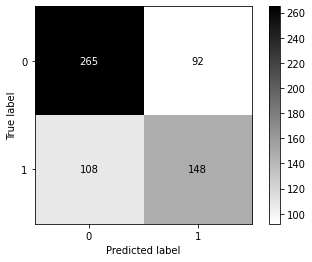

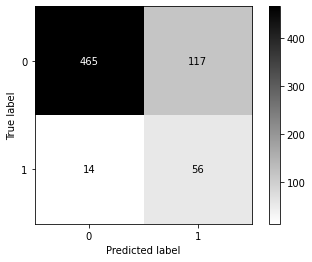

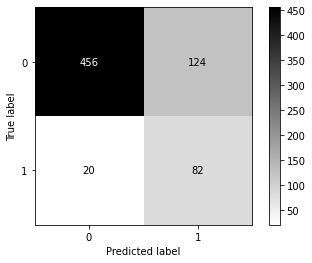

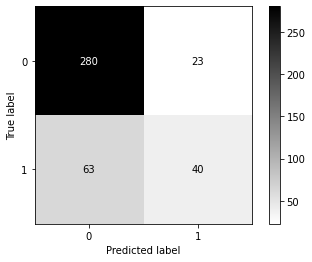

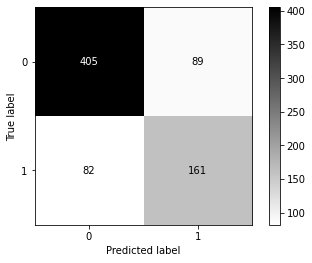

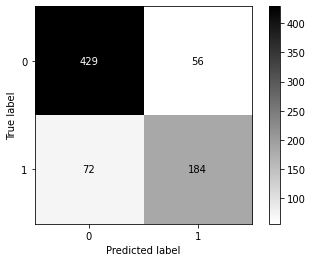

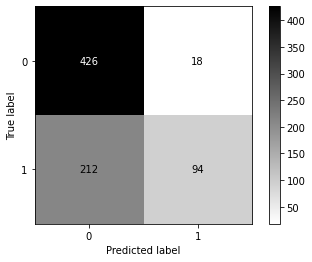

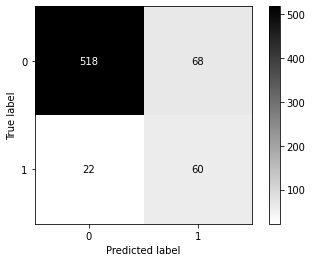

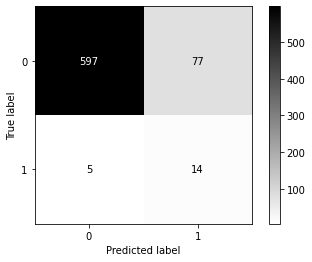

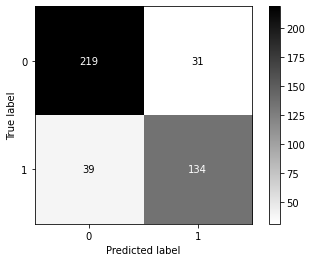

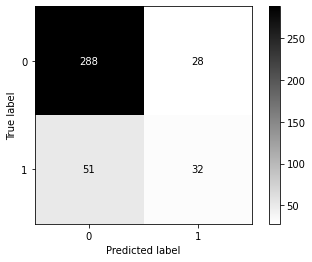

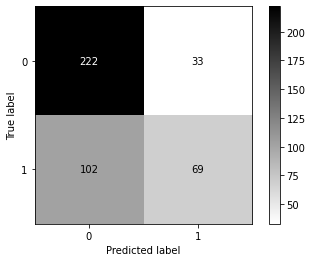

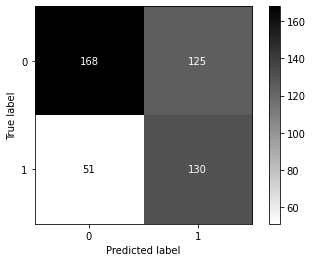

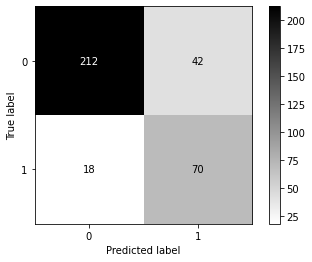

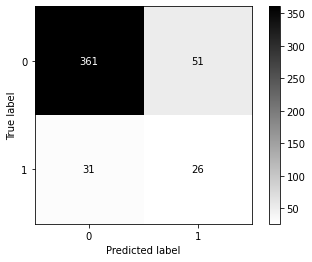

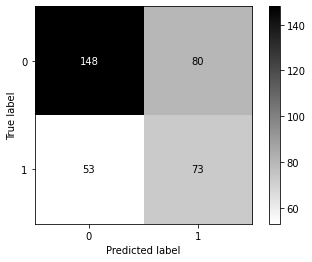

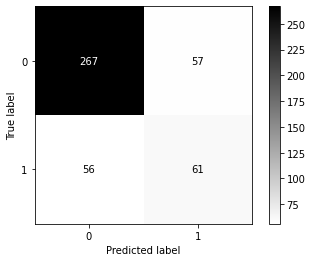

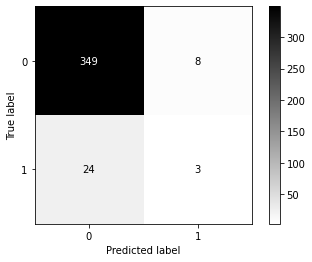

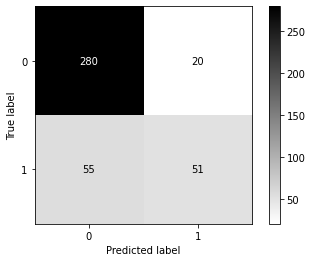

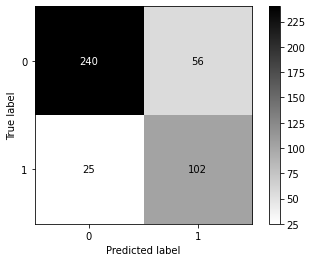

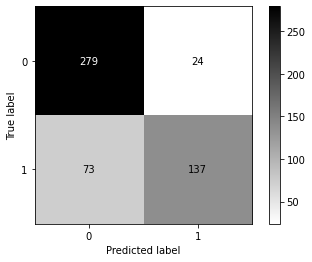

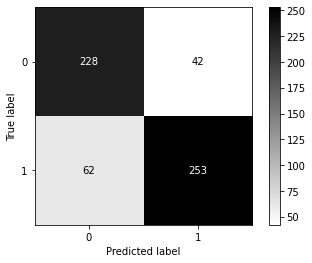

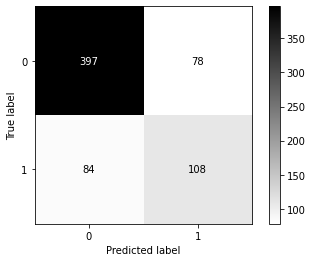

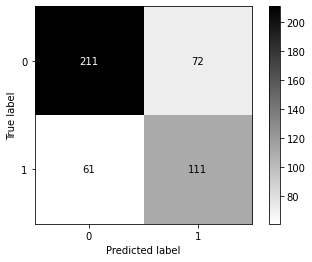

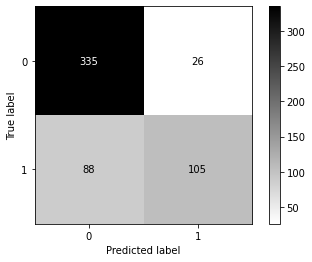

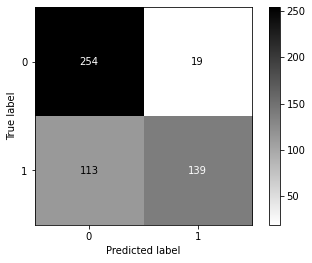

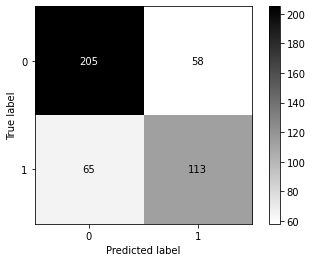

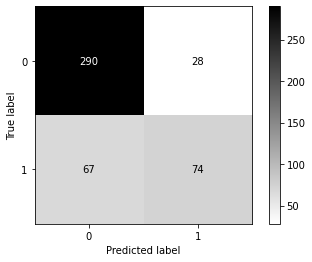

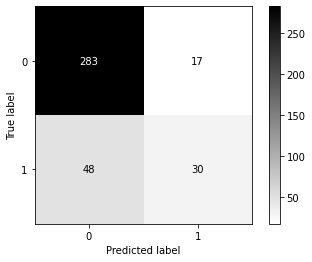

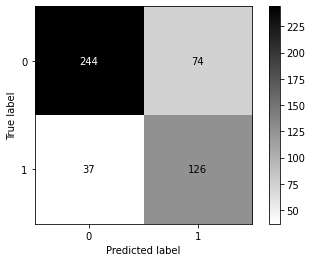

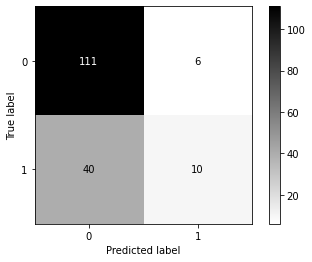

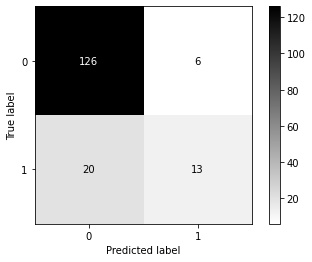

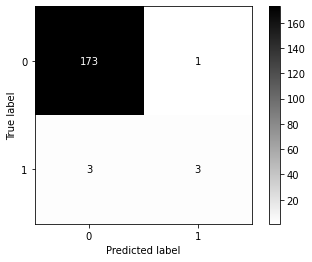

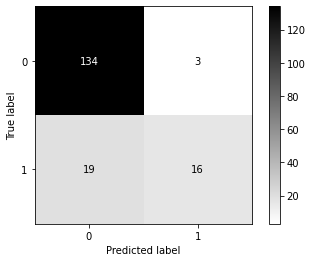

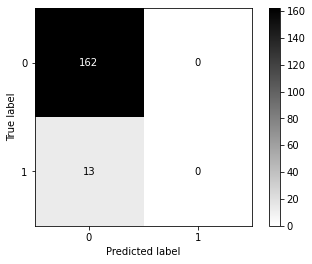

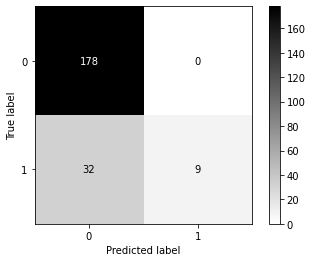

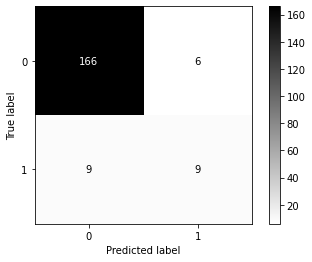

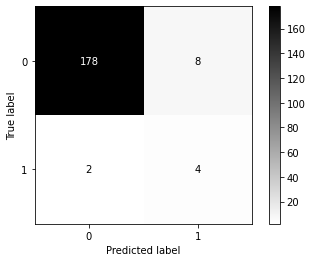

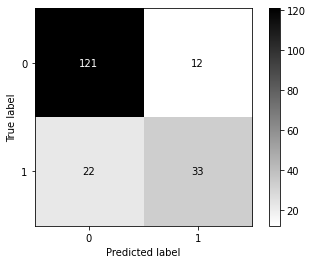

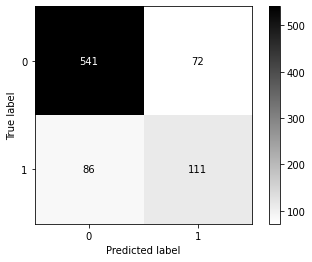

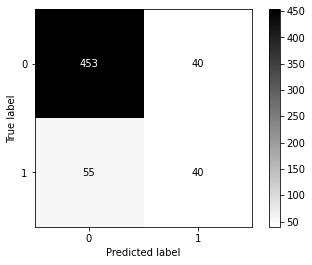

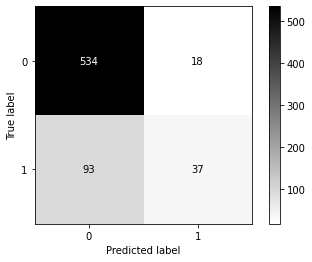

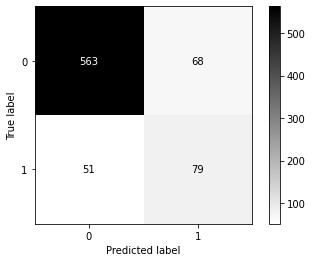

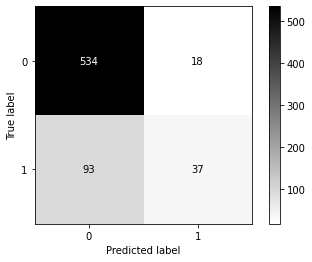

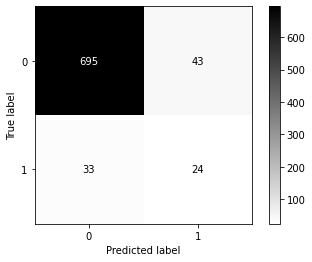

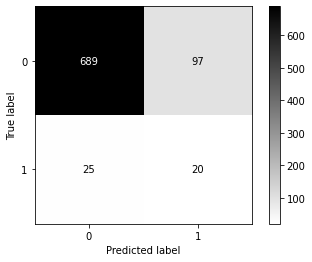

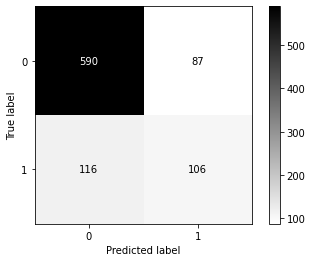

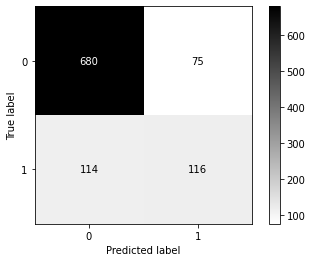

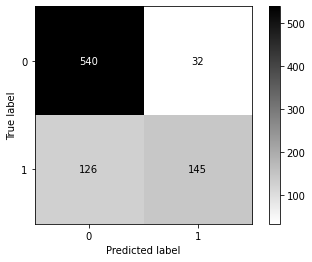

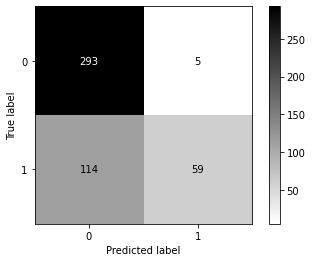

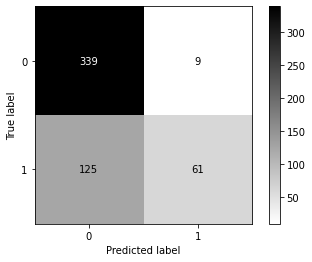

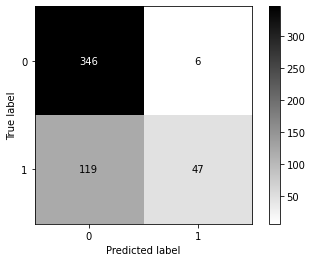

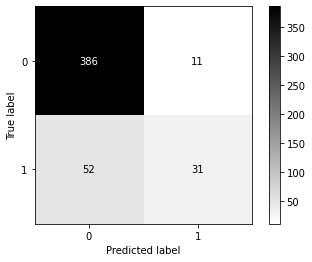

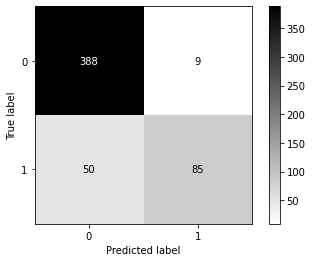

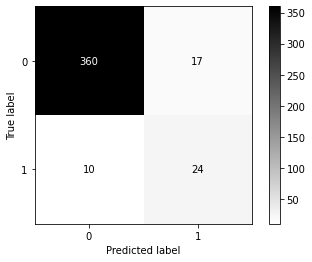

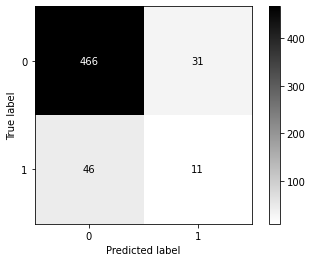

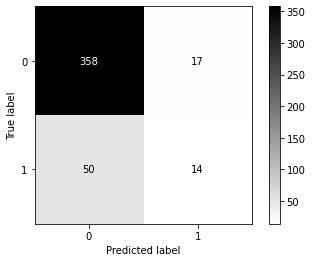

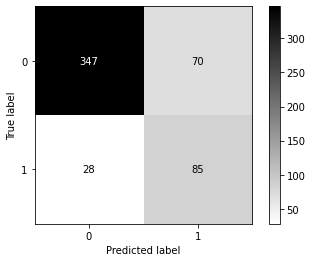

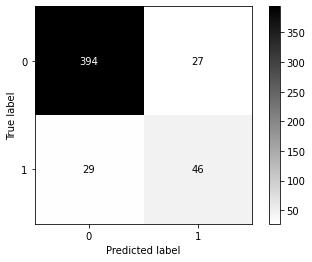

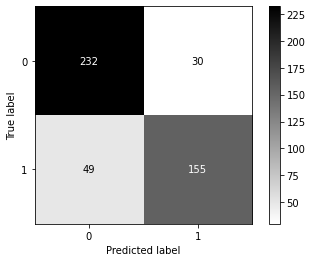

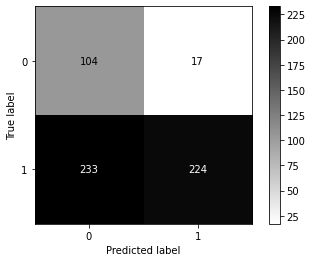

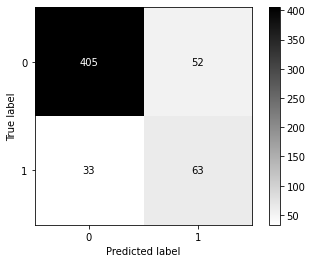

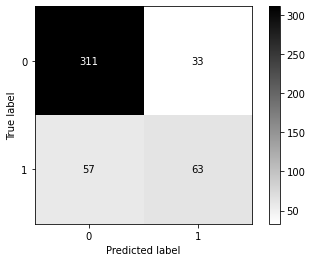

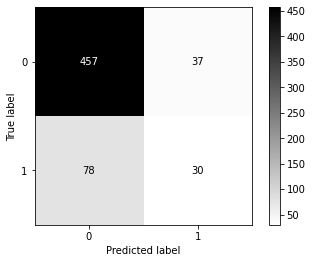

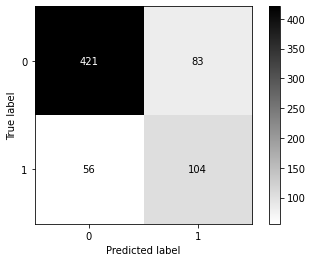

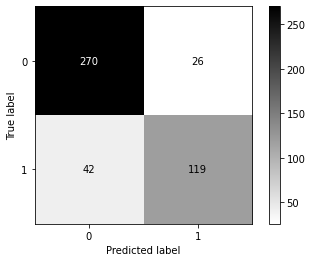

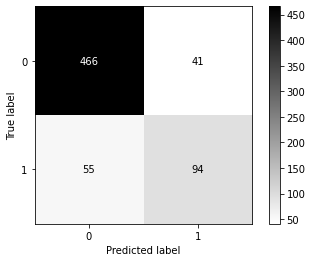

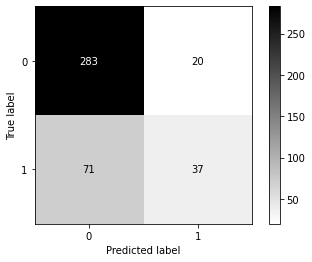

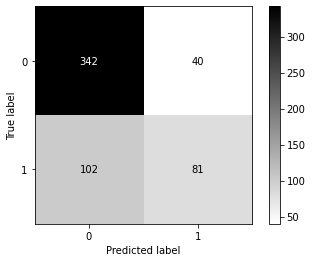

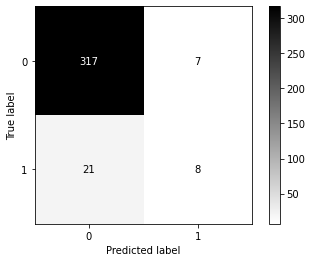

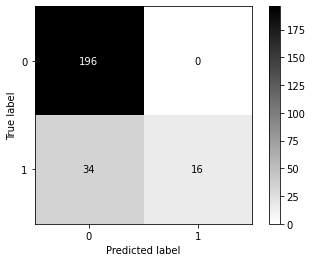

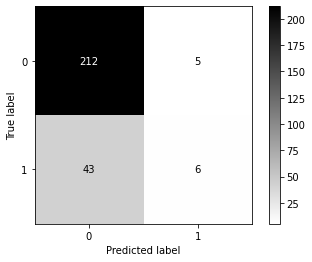

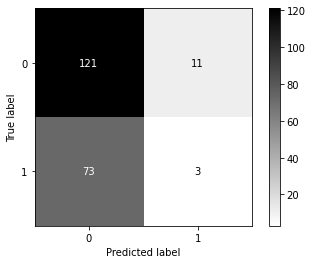

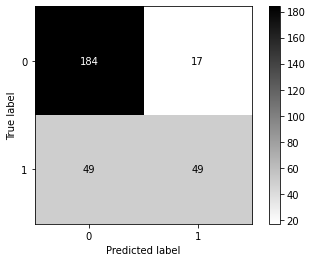

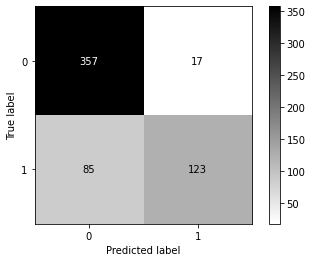

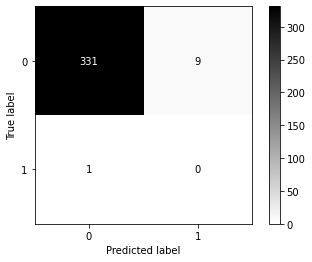

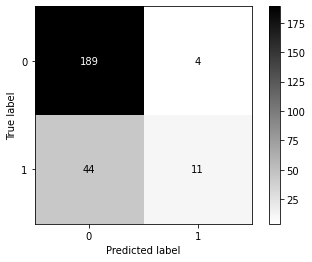

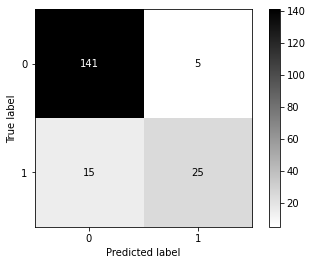

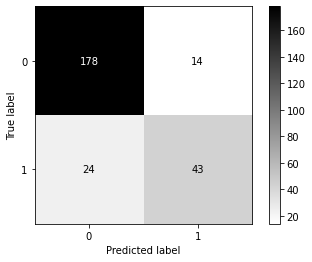

In [52]:
sc,dic,_,_=model_utils.get_report_by_unit(ens_pred,'ens','group',n_t=2, print_rep=True, segeval =False, use_par=False)

In [53]:
f1_rec=[]
for k,v in dic.items():
    f1_rec.append(v['1']['recall'])

In [54]:
np.mean(f1_rec)

0.4959863388583449

In [58]:
sent_db

,doc_idx,sent_idx,is_nar,nar_idx
0,1,0,0.00000,0.00000
1,1,1,0.00000,0.00000
2,1,2,0.00000,0.00000
3,1,3,0.00000,0.00000
4,1,4,0.00000,0.00000
...,...,...,...,...
38429,80,525,0.00000,0.00000
38430,80,526,0.00000,0.00000
38431,80,527,0.00000,0.00000
38432,80,528,0.00000,0.00000


In [59]:
sent_db[sent_db['is_nar']==1]['nar_idx'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18.])

In [60]:
nar_idx_db=sent_db.merge(ens_pred[['ens_true','ens_predicted','ens_group','sent_idx']],left_on=['doc_idx','sent_idx'],right_on=['ens_group','sent_idx'],validate='one_to_one')

In [61]:
nar_idx_db[nar_idx_db['ens_true']==1].shape[0]

9856

In [62]:
nar_idx_db[nar_idx_db['ens_predicted']==1].shape[0]

8210

In [63]:
rec=len(set(nar_idx_db[nar_idx_db['ens_true']==1].index)&set(nar_idx_db[nar_idx_db['ens_predicted']==1].index))/len(nar_idx_db[nar_idx_db['ens_true']==1])
rec

0.539265422077922

In [196]:
common_utils.save_db(nar_idx_db,dir_name,'nar_idx_db')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/nar_idx_db.csv, 
index False
float_format %.5f


In [64]:
true_nar_len=nar_idx_db[nar_idx_db['is_nar']==1].groupby(['doc_idx','nar_idx']).size().reset_index(name='nar_len')
true_nar_len

,doc_idx,nar_idx,nar_len
0,1,1.00000,43
1,1,2.00000,24
2,1,3.00000,19
3,1,4.00000,11
4,1,5.00000,22
...,...,...,...
643,79,13.00000,1
644,80,1.00000,11
645,80,2.00000,40
646,80,3.00000,45


In [198]:
common_utils.save_db(true_nar_len,dir_name,'true_nar_len')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/true_nar_len.csv, 
index False
float_format %.5f


In [65]:
# df.name2.eq(df.name1)
pred_hit=nar_idx_db[(nar_idx_db['ens_true'].eq(nar_idx_db['ens_predicted']))&(nar_idx_db['ens_true']==1)].groupby(['doc_idx','nar_idx']).size().reset_index(name='pred_hit')
pred_hit

,doc_idx,nar_idx,pred_hit
0,1,1.00000,7
1,1,2.00000,24
2,1,3.00000,16
3,1,4.00000,2
4,1,5.00000,8
...,...,...,...
451,79,11.00000,5
452,80,1.00000,8
453,80,2.00000,29
454,80,3.00000,43


In [200]:
common_utils.save_db(pred_hit,dir_name,'pred_hit_len')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/pred_hit_len.csv, 
index False
float_format %.5f


In [201]:
compare=true_nar_len.merge(pred_hit,left_on=['doc_idx','nar_idx'],right_on=['doc_idx','nar_idx'],how='outer',validate='one_to_one')

In [202]:
compare['hit_ratio']=compare['pred_hit']/compare['nar_len']

In [214]:
compare

,doc_idx,nar_idx,nar_len,pred_hit,hit_ratio
0,1,1.00000,43,7.00000,0.16279
1,1,2.00000,24,24.00000,1.00000
2,1,3.00000,19,13.00000,0.68421
3,1,4.00000,11,2.00000,0.18182
4,1,5.00000,22,8.00000,0.36364
...,...,...,...,...,...
643,79,13.00000,1,NaN,NaN
644,80,1.00000,11,7.00000,0.63636
645,80,2.00000,40,24.00000,0.60000
646,80,3.00000,45,40.00000,0.88889


In [216]:
compare.groupby('doc_idx')['nar_idx'].max()

doc_idx
1    13.00000
2     4.00000
3     9.00000
4     6.00000
5    13.00000
       ...   
76    8.00000
77    5.00000
78    6.00000
79   13.00000
80    4.00000
Name: nar_idx, Length: 79, dtype: float64

In [204]:
compare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 647
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   doc_idx    648 non-null    int64  
 1   nar_idx    648 non-null    float64
 2   nar_len    648 non-null    int64  
 3   pred_hit   412 non-null    float64
 4   hit_ratio  412 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 30.4 KB


In [205]:
compare['pred_hit'].count()*100/compare['nar_len'].count()

63.58024691358025

In [206]:
threshold=0.3

In [207]:
compare[compare['hit_ratio']>=threshold].shape[0]

356

In [208]:
compare[compare['hit_ratio']>=0.5].shape[0]*100/compare['nar_len'].count()

44.75308641975309

In [209]:
compare[compare['hit_ratio']>=threshold].shape[0]*100/compare['nar_len'].count()

54.93827160493827

<AxesSubplot:ylabel='Frequency'>

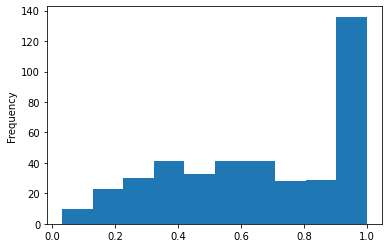

In [210]:
compare['hit_ratio'].plot(kind='hist',bins=10)

In [177]:
np.nanpercentile(compare['hit_ratio'],50)

0.7717121588089331

In [179]:
np.nanquantile(compare['hit_ratio'],0.5)

0.7717121588089331

In [173]:
compare[compare['hit_ratio']>=threshold].shape[0]

333

In [211]:
common_utils.save_db(compare,dir_name,'nar_hit_ratio')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/nar_hit_ratio.csv, 
index False
float_format %.5f


In [212]:
threshold=0.5
compare[compare['hit_ratio']>threshold].shape[0]

276

### Find true narratives

In [17]:
# fixed_df=my_tables[best_fix].my_fixer.fixed_df.copy()
fixed_df=common_utils.load_db(dir_name,'all_pred_fixed.threshold0.256')
non_fixed_df=common_utils.load_db(dir_name,'all_pred.threshold0.256')

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/all_pred_fixed.threshold0.256.csv,  index False
Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/all_pred.threshold0.256.csv,  index False


In [28]:
tot_doc_num=len(fixed_df['ens_group'].unique())
tot_doc_num

79

In [29]:
consecutives=fixed_df.groupby('ens_group')['ens_true'].diff().ne(0).cumsum()
consecutives

0           1
1           1
2           1
3           1
4           1
         ... 
38429    1353
38430    1353
38431    1353
38432    1353
38433    1353
Name: ens_true, Length: 38434, dtype: int64

In [30]:
(len(fixed_df.groupby(consecutives).size())-tot_doc_num)/2

637.0

In [31]:
fixed_df['abs_idx']=fixed_df.index
fixed_df

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,sent_idx,crf_group,...,crf_proba_1,crf_sent_idx,ens_predicted,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true,ens_par,abs_idx
0,1,0,1,0,0.45525,0.54475,0,0,0,1,...,0.07000,0,0,0.84699,0.15301,1,0,0,0,0
1,1,0,0,0,0.76593,0.23407,1,1,1,1,...,0.05700,1,0,0.84595,0.15405,1,0,0,1,1
2,1,0,0,0,0.79398,0.20602,2,2,2,1,...,0.02800,2,0,0.84583,0.15417,1,0,0,2,2
3,1,0,0,0,0.59757,0.40243,3,3,3,1,...,0.04300,3,0,0.84611,0.15389,1,0,0,3,3
4,1,0,1,0,0.40709,0.59291,4,4,4,1,...,0.03200,4,0,0.84717,0.15283,1,0,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38429,79,7,0,0,0.70014,0.29986,2983,171,254,79,...,0.12800,2983,0,0.84198,0.15802,79,7,0,171,38429
38430,79,7,0,0,0.84534,0.15466,2984,172,255,79,...,0.00600,2984,0,0.84326,0.15674,79,7,0,172,38430
38431,79,7,0,0,0.85442,0.14558,2985,172,256,79,...,0.00100,2985,0,0.84387,0.15613,79,7,0,172,38431
38432,79,7,0,0,0.84201,0.15799,2986,172,257,79,...,0.00000,2986,0,0.84348,0.15652,79,7,0,172,38432


In [32]:
fixed_df[fixed_df['ens_true']==1]

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,sent_idx,crf_group,...,crf_proba_1,crf_sent_idx,ens_predicted,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true,ens_par,abs_idx
21,1,0,1,1,0.24310,0.75690,21,15,21,1,...,0.55700,21,1,0.41233,0.58767,1,0,1,15,21
22,1,0,1,1,0.12920,0.87080,22,15,22,1,...,0.57600,22,1,0.18496,0.81504,1,0,1,15,22
23,1,0,1,1,0.27369,0.72631,23,15,23,1,...,0.55700,23,1,0.48338,0.51662,1,0,1,15,23
24,1,0,1,1,0.47378,0.52622,24,15,24,1,...,0.52700,24,0,0.79679,0.20321,1,0,1,15,24
25,1,0,0,1,0.64954,0.35046,25,16,25,1,...,0.40900,25,0,0.84968,0.15032,1,0,1,16,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38355,79,7,1,1,0.29014,0.70986,2909,120,180,79,...,0.22900,2909,1,0.82778,0.17222,79,7,1,120,38355
38356,79,7,1,1,0.11229,0.88771,2910,121,181,79,...,0.23400,2910,1,0.64714,0.35286,79,7,1,121,38356
38357,79,7,1,1,0.23509,0.76491,2911,121,182,79,...,0.22300,2911,0,0.80433,0.19567,79,7,1,121,38357
38364,79,7,1,1,0.15080,0.84920,2918,127,189,79,...,0.06800,2918,0,0.83150,0.16850,79,7,1,127,38364


In [33]:
agg_true=fixed_df[['abs_idx','ens_true']].groupby(consecutives).agg(list).copy()

In [34]:
imp.reload(common_utils)
agg_true['is_nar']=agg_true['ens_true'].apply(common_utils.get_single_unique)

In [35]:
agg_true['is_nar'].diff().ne(0).cumsum()

ens_true
1          1
2          2
3          3
4          4
5          5
        ... 
1349    1275
1350    1276
1351    1277
1352    1278
1353    1279
Name: is_nar, Length: 1353, dtype: int64

In [248]:
common_utils.save_db(agg_true[agg_true['is_nar']==1],dir_name,'true_nar_aggr')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/true_nar_aggr.csv, 
index False
float_format %.5f


### Find pred narratives

In [36]:
consecutives_pred=fixed_df.groupby('ens_group')['ens_predicted'].diff().ne(0).cumsum()
consecutives_pred

0           1
1           1
2           1
3           1
4           1
         ... 
38429    2294
38430    2294
38431    2294
38432    2294
38433    2294
Name: ens_predicted, Length: 38434, dtype: int64

In [37]:
fixed_df['abs_idx']=fixed_df.index

In [38]:
imp.reload(common_utils)
agg_pred=fixed_df[['abs_idx','ens_predicted','ens_group','ens_true']].groupby(consecutives_pred).agg(list).copy()
agg_pred['is_nar']=agg_pred['ens_predicted'].apply(common_utils.get_single_unique)
agg_pred['doc_idx']=agg_pred['ens_group'].apply(common_utils.get_single_unique)
agg_pred['hit_true']=agg_pred['ens_true'].apply(common_utils.get_single_unique)

In [39]:
agg_pred

,abs_idx,ens_predicted,ens_group,ens_true,is_nar,doc_idx,hit_true
ens_predicted,,,,,,,
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,0
2,"[21, 22, 23]","[1, 1, 1]","[1, 1, 1]","[1, 1, 1]",1,1,1
3,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,1,1
4,"[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,1,1
5,"[75, 76, 77, 78, 79, 80]","[0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]",0,1,0
...,...,...,...,...,...,...,...
2290,"[38345, 38346, 38347]","[0, 0, 0]","[79, 79, 79]","[1, 1, 1]",0,79,1
2291,[38348],[1],[79],[1],1,79,1
2292,"[38349, 38350, 38351, 38352, 38353]","[0, 0, 0, 0, 0]","[79, 79, 79, 79, 79]","[1, 1, 1, 1, 1]",0,79,1


In [40]:
agg_pred['nar_len'] = agg_pred.abs_idx.map(len)

In [41]:
len_more_1 = agg_pred[(agg_pred['nar_len']>1)&(agg_pred['is_nar']==1)].shape[0]
len_more_1

897

In [42]:
len_more_1 = agg_pred[(agg_pred['nar_len']>1)&(agg_pred['is_nar']==1)].shape[0]
len_more_2 = agg_pred[(agg_pred['nar_len']>2)&(agg_pred['is_nar']==1)].shape[0]

In [43]:
len_more_2/len_more_1

0.8071348940914158

In [44]:
agg_pred[(agg_pred['is_nar']==1)&(agg_pred['nar_len']>1)]['nar_len'].describe()

count   897.00000
mean      8.91081
std       9.73034
min       2.00000
25%       3.00000
50%       5.00000
75%      11.00000
max      91.00000
Name: nar_len, dtype: float64

### Find EXTRA narrative that has no intersection with actual

In [45]:
extra = agg_pred[(agg_pred['nar_len']>1)&(agg_pred['is_nar']==1)&(agg_pred['hit_true']==0)].shape[0]
extra

401

In [46]:
hit = agg_pred[(agg_pred['nar_len']>1)&(agg_pred['is_nar']==1)&(agg_pred['hit_true']==1)].shape[0]
hit

496

In [47]:
agg_pred[(agg_pred['nar_len']>1)&(agg_pred['is_nar']==1)&(agg_pred['hit_true']==1)]['nar_len'].describe()

count   496.00000
mean      9.60887
std      10.49099
min       2.00000
25%       3.00000
50%       6.00000
75%      12.00000
max      91.00000
Name: nar_len, dtype: float64

In [66]:
agg_pred[(agg_pred['nar_len']>1)&(agg_pred['is_nar']==1)&(agg_pred['hit_true']==0)]['nar_len'].describe()

count   401.00000
mean      8.04738
std       8.63309
min       2.00000
25%       3.00000
50%       5.00000
75%      10.00000
max      71.00000
Name: nar_len, dtype: float64

## Find extra narratives via class

In [18]:
imp.reload(classes)
bool_rec={}
prefix='ens'
bool_rec[prefix]=classes.MyBooleanRecall(dir_name,fixed_df,prefix)


init >> MyBooleanRecall ens


In [19]:
bool_rec[prefix].stat

{'total_true_narrative': 648,
 'tp': 456,
 'fn': 192,
 'total_pred_narrative': 897,
 'fp': 441,
 'recall': 0.7037037037037037,
 'precision': 0.5083612040133779,
 'f1': 0.5902912621359223}

In [20]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(pd.DataFrame(bool_rec[prefix].stat,index=[0]))

,total_true_narrative,tp,fn,total_pred_narrative,fp,recall,precision,f1
0,648,456,192,897,441,0.704,0.508,0.590


## Find boolean recall for base

In [4]:
base_pred=common_utils.load_db(dir_name,'tf.base.pred.char')
# bool_rec={}

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/tf.base.pred.char.csv,  index False


In [10]:
k='base'
base_pred = base_pred.assign(
            sent_idx=base_pred.groupby(['{}_group'.format(k)]).cumcount())
base_pred

,base_predicted,base_group,base_split,base_true,sent_idx
0,0,19,0,0,0
1,0,19,0,0,1
2,0,19,0,0,2
3,0,19,0,0,3
4,0,19,0,0,4
...,...,...,...,...,...
38429,0,16,7,0,418
38430,1,16,7,0,419
38431,0,16,7,0,420
38432,0,16,7,0,421


In [11]:
base_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38434 entries, 0 to 38433
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   base_predicted  38434 non-null  int64
 1   base_group      38434 non-null  int64
 2   base_split      38434 non-null  int64
 3   base_true       38434 non-null  int64
 4   sent_idx        38434 non-null  int64
dtypes: int64(5)
memory usage: 1.5 MB


In [28]:
imp.reload(classes)
prefix='base'
bool_rec[prefix]=classes.MyBooleanRecall(dir_name,base_pred,prefix)
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(pd.DataFrame(bool_rec[prefix].stat,index=[0]))

init >> MyBooleanRecall base


,total_true_narrative,tp,fn,total_pred_narrative,fp,recall,precision,f1
0,648,567,81,834,267,0.875,0.680,0.765


In [14]:
hit_name="ratio of covered narrative sentences"

Text(0.5, 1.0, 'BASELINE ratio of covered narrative setntences')

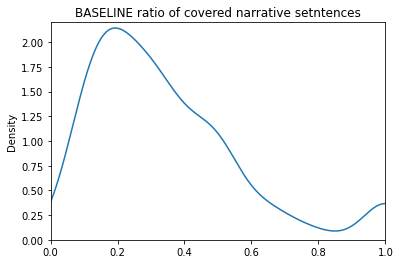

In [39]:
ax=bool_rec['base'].compare['hit_ratio'].plot(kind='kde')
ax.set_xlim((0,1))
ax.set_ylim((0,2.2))
ax.set_title("BASELINE "+hit_name)

(0.0, 2.2)

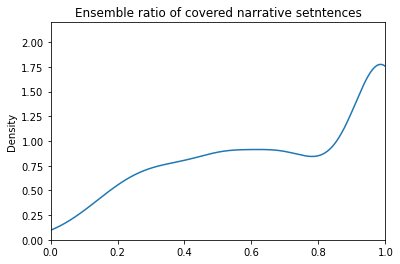

In [43]:
ax=bool_rec['ens_fix'].compare['hit_ratio'].plot(kind='kde')
ax.set_title("Ensemble "+hit_name)

ax.set_xlim((0,1))
ax.set_ylim((0,2.2))

In [44]:
bool_rec['ens_fix'].compare['hit_ratio'].describe()

count    456.000000
mean       0.691045
std        0.289522
min        0.033333
25%        0.465385
50%        0.717143
75%        1.000000
max        1.000000
Name: hit_ratio, dtype: float64

In [45]:
bool_rec['base'].compare['hit_ratio'].describe()

count    567.000000
mean       0.347142
std        0.233456
min        0.033333
25%        0.172671
50%        0.285714
75%        0.461538
max        1.000000
Name: hit_ratio, dtype: float64

## Find boolean recall for BERT

In [51]:
final_pred=common_utils.load_db(dir_name,'all_pred_fixed.threshold0.256')

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/all_pred_fixed.threshold0.256.csv,  index False


In [22]:
imp.reload(classes)
prefix='bert'
bool_rec[prefix]=classes.MyBooleanRecall(dir_name,fixed_df,prefix)
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(pd.DataFrame(bool_rec[prefix].stat,index=[0]))

init >> MyBooleanRecall bert


,total_true_narrative,tp,fn,total_pred_narrative,fp,recall,precision,f1
0,648,635,13,2340,1705,0.980,0.271,0.425


## Find boolean recall for CRF

In [23]:
imp.reload(classes)
prefix='crf'
bool_rec[prefix]=classes.MyBooleanRecall(dir_name,fixed_df,prefix)
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(pd.DataFrame(bool_rec[prefix].stat,index=[0]))

init >> MyBooleanRecall crf


,total_true_narrative,tp,fn,total_pred_narrative,fp,recall,precision,f1
0,648,336,312,427,91,0.519,0.787,0.625


## Find boolean recall for ensemble fixed

In [24]:
imp.reload(classes)
prefix='ens'
bool_rec[prefix+'_fix']=classes.MyBooleanRecall(dir_name,fixed_df,prefix)
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(pd.DataFrame(bool_rec[prefix+'_fix'].stat,index=[0]))

init >> MyBooleanRecall ens


,total_true_narrative,tp,fn,total_pred_narrative,fp,recall,precision,f1
0,648,456,192,897,441,0.704,0.508,0.590


In [25]:
imp.reload(classes)
prefix='ens'
bool_rec[prefix]=classes.MyBooleanRecall(dir_name,non_fixed_df,prefix)
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(pd.DataFrame(bool_rec[prefix].stat,index=[0]))

init >> MyBooleanRecall ens


,total_true_narrative,tp,fn,total_pred_narrative,fp,recall,precision,f1
0,648,515,133,960,445,0.795,0.536,0.641


## Combine all metrix together

In [29]:
boolean_all=pd.DataFrame()
for k,v in bool_rec.items():
    boolean_all.loc['boolean recall',k]=v.stat['recall']
    boolean_all.loc['boolean precision',k]=v.stat['precision']
    boolean_all.loc['boolean f1',k]=v.stat['f1']
boolean_all.sort_index(axis=1,inplace=True)

In [30]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(boolean_all)

,base,bert,crf,ens,ens_fix
boolean recall,0.875,0.980,0.519,0.795,0.704
boolean precision,0.680,0.271,0.787,0.536,0.508
boolean f1,0.765,0.425,0.625,0.641,0.590


In [166]:
boolean_all.to_csv()

',base,bert,crf,ens,ens_fix\nboolean recall,0.875,0.9799382716049383,0.5185185185185185,0.7947530864197531,0.7037037037037037\nboolean precision,0.6798561151079137,0.27136752136752135,0.7868852459016393,0.5364583333333334,0.5083612040133779\nboolean f1,0.7651821862348178,0.42503346720214186,0.6251162790697674,0.640547263681592,0.5902912621359223\n'

In [167]:
common_utils.save_db(boolean_all,dir_name,'boolean.metrics.all',True)

Saving /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/boolean.metrics.all.csv, 
index True
float_format %.5f


### Try to train ensemble on merged predictions

In [333]:
cv_splits_loaded=common_utils.load_json(dir_name,cv_split_name)
cv_splits_loaded

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_splits_10.json


{'0': {'test': [4, 14, 15, 18, 29, 32, 36, 70],
  'train': [1,
   2,
   3,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   16,
   17,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   30,
   31,
   33,
   34,
   35,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80]},
 '1': {'test': [5, 6, 13, 34, 37, 62, 73, 80],
  'train': [1,
   2,
   3,
   4,
   7,
   8,
   9,
   10,
   11,
   12,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   35,
   36,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   6

In [336]:
fixed_pred=my_tables_sinle_on_pred.my_fixer.fixed_df.copy()

In [337]:
from sklearn.svm import SVC
imp.reload(model_utils)
ens_pred=model_utils.prepared_cross_validate_ensemble(SVC(random_state=0),fixed_pred,cv_splits_loaded,False)

0 split started...
1 split started...
2 split started...
3 split started...
4 split started...
5 split started...
6 split started...
7 split started...
8 split started...
9 split started...


In [338]:
scores, scores_dict, _, _ = model_utils.get_report_by_unit(ens_pred,'ens',"split")

In [340]:
np.mean(scores)

0.7748702825183011

In [342]:
ens_pred_plane=model_utils.prepared_cross_validate_ensemble(SVC(random_state=0),my_tables_sinle_on_pred.my_fixer.pred_df,cv_splits_loaded,False)

0 split started...
1 split started...
2 split started...
3 split started...
4 split started...
5 split started...
6 split started...
7 split started...
8 split started...
9 split started...


In [343]:
scores_plane, scores_dict_plane, _, _ = model_utils.get_report_by_unit(ens_pred_plane,'ens',"split")
np.mean(scores_plane)

0.7617807647672052

### Add plot of fixed ensemble

In [345]:
fixed_f1_score=common_utils.load_db(dir_name,'bert.cfg.svc.weighted_f1.fixed',True)

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert.cfg.svc.weighted_f1.fixed.csv,  index True


In [347]:
pure_f1_score=common_utils.load_db(dir_name,'bert.cfg.svc.weighted_f1.pure',True)

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert.cfg.svc.weighted_f1.pure.csv,  index True


In [350]:
f1_score=common_utils.load_db(dir_name,'bert.cfg.svc.weighted_f1',True)

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert.cfg.svc.weighted_f1.csv,  index True


In [348]:
fixed_f1_score

,Unnamed: 0,bert,crf,ens
0,0,0.83515,0.81135,0.83368
1,1,0.80885,0.75450,0.78396
2,2,0.81342,0.77111,0.78792
3,3,0.77587,0.74848,0.78180
4,4,0.79152,0.78009,0.78384
5,5,0.81002,0.76068,0.78793
6,6,0.84801,0.83285,0.85487
7,7,0.77328,0.81058,0.82617
8,8,0.80453,0.82589,0.84774
9,9,0.78907,0.72938,0.78169


In [349]:
pure_f1_score

,Unnamed: 0,bert,crf,ens
0,0,0.78029,0.80963,0.81835
1,1,0.73063,0.75374,0.77188
2,2,0.75184,0.76873,0.77385
3,3,0.71842,0.74690,0.76610
4,4,0.72983,0.77839,0.77550
5,5,0.75766,0.75900,0.77321
6,6,0.79431,0.83151,0.83864
7,7,0.72026,0.80980,0.81446
8,8,0.74909,0.82563,0.83403
9,9,0.71354,0.72851,0.76171


In [351]:
f1_score

,Unnamed: 0,base,bert,crf,ens
0,0,0.75156,0.83515,0.81135,0.83368
1,1,0.71553,0.80885,0.75450,0.78396
2,2,0.72088,0.81342,0.77111,0.78792
3,3,0.71118,0.77587,0.74848,0.78180
4,4,0.71024,0.79152,0.78009,0.78384
5,5,0.71019,0.81002,0.76068,0.78793
6,6,0.79182,0.84801,0.83285,0.85487
7,7,0.76333,0.77328,0.81058,0.82617
8,8,0.78739,0.80453,0.82589,0.84774
9,9,0.65185,0.78907,0.72938,0.78169


In [352]:
full_scores=pure_f1_score.merge(f1_score[['base']],left_index=True,right_index=True,validate='one_to_one')

In [354]:
full_scores=full_scores.merge(fixed_f1_score[['ens']],left_index=True,right_index=True,validate='one_to_one')
full_scores

,Unnamed: 0,bert,crf,ens_x,base,ens_y
0,0,0.78029,0.80963,0.81835,0.75156,0.83368
1,1,0.73063,0.75374,0.77188,0.71553,0.78396
2,2,0.75184,0.76873,0.77385,0.72088,0.78792
3,3,0.71842,0.74690,0.76610,0.71118,0.78180
4,4,0.72983,0.77839,0.77550,0.71024,0.78384
5,5,0.75766,0.75900,0.77321,0.71019,0.78793
6,6,0.79431,0.83151,0.83864,0.79182,0.85487
7,7,0.72026,0.80980,0.81446,0.76333,0.82617
8,8,0.74909,0.82563,0.83403,0.78739,0.84774
9,9,0.71354,0.72851,0.76171,0.65185,0.78169


In [355]:
full_scores.rename({'ens_x':'ens','ens_y':'fixed'},axis=1,inplace=True)
full_scores

,Unnamed: 0,bert,crf,ens,base,fixed
0,0,0.78029,0.80963,0.81835,0.75156,0.83368
1,1,0.73063,0.75374,0.77188,0.71553,0.78396
2,2,0.75184,0.76873,0.77385,0.72088,0.78792
3,3,0.71842,0.74690,0.76610,0.71118,0.78180
4,4,0.72983,0.77839,0.77550,0.71024,0.78384
5,5,0.75766,0.75900,0.77321,0.71019,0.78793
6,6,0.79431,0.83151,0.83864,0.79182,0.85487
7,7,0.72026,0.80980,0.81446,0.76333,0.82617
8,8,0.74909,0.82563,0.83403,0.78739,0.84774
9,9,0.71354,0.72851,0.76171,0.65185,0.78169


In [357]:
full_scores.loc['mean'] = full_scores.mean()

In [361]:
common_utils.save_db(full_scores,dir_name,'bert.cfg.svc.weighted_f1.pure.and.fixed',False)

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert.cfg.svc.weighted_f1.pure.and.fixed.csv, 
index False
float_format %.5f


In [360]:
full_scores

,Unnamed: 0,bert,crf,ens,base,fixed
0,0.00000,0.78029,0.80963,0.81835,0.75156,0.83368
1,1.00000,0.73063,0.75374,0.77188,0.71553,0.78396
2,2.00000,0.75184,0.76873,0.77385,0.72088,0.78792
3,3.00000,0.71842,0.74690,0.76610,0.71118,0.78180
4,4.00000,0.72983,0.77839,0.77550,0.71024,0.78384
5,5.00000,0.75766,0.75900,0.77321,0.71019,0.78793
6,6.00000,0.79431,0.83151,0.83864,0.79182,0.85487
7,7.00000,0.72026,0.80980,0.81446,0.76333,0.82617
8,8.00000,0.74909,0.82563,0.83403,0.78739,0.84774
9,9.00000,0.71354,0.72851,0.76171,0.65185,0.78169


In [363]:
full_scores.loc['mean'].transpose()

Unnamed: 0   4.50000
bert         0.74459
crf          0.78118
ens          0.79277
base         0.73140
fixed        0.80696
Name: mean, dtype: float64

In [364]:
per_label=common_utils.load_db(dir_name,"bert.cfg.svc.per.fold_f1.pure")

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert.cfg.svc.per.fold_f1.pure.csv,  index False


In [365]:
per_label

,Unnamed: 0,bert_1,bert_0,crf_1,crf_0,ens_1,ens_0
0,1,0.52347,0.85753,0.55279,0.88687,0.55172,0.89853
1,2,0.52371,0.80492,0.46722,0.85659,0.49597,0.87093
2,3,0.53370,0.83174,0.54064,0.85227,0.51705,0.86791
3,4,0.53235,0.78910,0.53751,0.82643,0.55607,0.84588
4,5,0.54094,0.81768,0.64000,0.84276,0.59779,0.85815
5,6,0.53488,0.84501,0.51271,0.85557,0.52308,0.87129
6,7,0.47746,0.86698,0.53502,0.89951,0.54207,0.90666
7,8,0.46407,0.79090,0.54009,0.88417,0.54881,0.88770
8,9,0.42435,0.81908,0.49487,0.89691,0.51558,0.90266
9,10,0.60267,0.77933,0.62458,0.79018,0.64804,0.82917


In [386]:
base_per_label=common_utils.load_db(dir_name,"base.per.label")
base_per_label

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/base.per.label.csv,  index False


,0.0_ngr,1.0_ngr,weighted avg_ngr
0,0.86936,0.35983,0.75156
1,0.84815,0.34608,0.71553
2,0.84931,0.37026,0.72088
3,0.83789,0.37762,0.71118
4,0.83739,0.40243,0.71024
5,0.84420,0.36842,0.71019
6,0.88865,0.36963,0.79182
7,0.87301,0.36558,0.76333
8,0.88595,0.33010,0.78739
9,0.78983,0.41932,0.65185


In [397]:
all_par_label=db.merge(base_per_label,left_index=True,right_index=True,validate='one_to_one',how='inner')

In [398]:
all_par_label.loc['mean']=all_par_label.mean()

In [399]:
all_par_label

,0_ens,1_ens,weighted avg_ens,0_crf,1_crf,weighted avg_crf,0_bert,1_bert,weighted avg_bert,0_fixed,1_fixed,weighted avg_fixed,0.0_ngr,1.0_ngr,weighted avg_ngr
0,0.89853,0.55172,0.81835,0.88687,0.55279,0.80963,0.85753,0.52347,0.78029,0.90151,0.56315,0.82328,0.86936,0.35983,0.75156
1,0.87093,0.49597,0.77188,0.85659,0.46722,0.75374,0.80492,0.52371,0.73063,0.87325,0.50619,0.77629,0.84815,0.34608,0.71553
2,0.86791,0.51705,0.77385,0.85227,0.54064,0.76873,0.83174,0.53370,0.75184,0.86974,0.52746,0.77798,0.84931,0.37026,0.72088
3,0.84588,0.55607,0.76610,0.82643,0.53751,0.74690,0.78910,0.53235,0.71842,0.84807,0.56865,0.77115,0.83789,0.37762,0.71118
4,0.85815,0.59779,0.77550,0.84276,0.64000,0.77839,0.81768,0.54094,0.72983,0.85750,0.59538,0.77428,0.83739,0.40243,0.71024
5,0.87129,0.52308,0.77321,0.85557,0.51271,0.75900,0.84501,0.53488,0.75766,0.87235,0.52733,0.77517,0.84420,0.36842,0.71019
6,0.90666,0.54207,0.83864,0.89951,0.53502,0.83151,0.86698,0.47746,0.79431,0.91051,0.56969,0.84692,0.88865,0.36963,0.79182
7,0.88770,0.54881,0.81446,0.88417,0.54009,0.80980,0.79090,0.46407,0.72026,0.88856,0.55588,0.81666,0.87301,0.36558,0.76333
8,0.90266,0.51558,0.83403,0.89691,0.49487,0.82563,0.81908,0.42435,0.74909,0.90417,0.52862,0.83758,0.88595,0.33010,0.78739
9,0.82917,0.64804,0.76171,0.79018,0.62458,0.72851,0.77933,0.60267,0.71354,0.83304,0.66374,0.76999,0.78983,0.41932,0.65185


In [421]:
all_par_label.loc['mean',all_par_label.columns.str.contains('ens')]

0_ens              0.87389
1_ens              0.54962
weighted avg_ens   0.79277
Name: mean, dtype: float64

In [406]:
all_par_label.rename({'0.0_ngr':'0_ngr','1.0_ngr':'1_ngr'},axis=1,inplace=True)

In [407]:
common_utils.save_db(all_par_label,dir_name,"all.per_label.mean")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/all.per_label.mean.csv, 
index False
float_format %.5f


In [408]:
all_par_label.loc['mean'].transpose()

0_ens                0.87389
1_ens                0.54962
weighted avg_ens     0.79277
0_crf                0.85913
1_crf                0.54454
weighted avg_crf     0.78118
0_bert               0.82023
1_bert               0.51576
weighted avg_bert    0.74459
0_fixed              0.87587
1_fixed              0.56061
weighted avg_fixed   0.79693
0_ngr                0.85237
1_ngr                0.37093
weighted avg_ngr     0.73140
Name: mean, dtype: float64

In [410]:
db_to_plot=pd.DataFrame()
for c in all_par_label.columns:
    splited=c.split('_')
    l=splited[0]
    t=splited[-1]
    print('l:{}, t:{}'.format(l,t))
    db_to_plot.loc[t,l]=all_par_label.loc['mean',c]
db_to_plot
        

l:0, t:ens
l:1, t:ens
l:weighted avg, t:ens
l:0, t:crf
l:1, t:crf
l:weighted avg, t:crf
l:0, t:bert
l:1, t:bert
l:weighted avg, t:bert
l:0, t:fixed
l:1, t:fixed
l:weighted avg, t:fixed
l:0, t:ngr
l:1, t:ngr
l:weighted avg, t:ngr


,0,1,weighted avg
ens,0.87389,0.54962,0.79277
crf,0.85913,0.54454,0.78118
bert,0.82023,0.51576,0.74459
fixed,0.87587,0.56061,0.79693
ngr,0.85237,0.37093,0.73140


In [411]:
common_utils.save_db(db_to_plot,dir_name,"f1.per_label.to_plot")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/f1.per_label.to_plot.csv, 
index False
float_format %.5f


In [418]:
trans=db_to_plot.transpose()

In [419]:
trans

,ens,crf,bert,fixed,ngr
0,0.87389,0.85913,0.82023,0.87587,0.85237
1,0.54962,0.54454,0.51576,0.56061,0.37093
weighted avg,0.79277,0.78118,0.74459,0.79693,0.73140


In [420]:
common_utils.save_db(trans,dir_name,"f1.per_label.to_plot",True)

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/f1.per_label.to_plot.csv, 
index True
float_format %.5f


### Get plain ensemble values for f1-score, prec and rec

In [422]:
ens_pred=common_utils.load_db(dir_name,'ens.SVC.pred.new.76.sent_idx')

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/ens.SVC.pred.new.76.sent_idx.csv,  index False


In [423]:
sc,dic,_,_=model_utils.get_report_by_unit(ens_pred,'ens',"split")

In [424]:
dic

{0: {'0': {'precision': 0.8499313186813187,
   'recall': 0.9530227185213708,
   'f1-score': 0.8985296787075693,
   'support': 2597},
  '1': {'precision': 0.7381974248927039,
   'recall': 0.44046094750320103,
   'f1-score': 0.5517241379310345,
   'support': 781},
  'accuracy': 0.8345174659561871,
  'macro avg': {'precision': 0.7940643717870113,
   'recall': 0.6967418330122859,
   'f1-score': 0.7251269083193019,
   'support': 3378},
  'weighted avg': {'precision': 0.8240982307449931,
   'recall': 0.8345174659561871,
   'f1-score': 0.818347580618027,
   'support': 3378}},
 1: {'0': {'precision': 0.8096221959858324,
   'recall': 0.9422878735829612,
   'f1-score': 0.8709318939514209,
   'support': 2911},
  '1': {'precision': 0.704225352112676,
   'recall': 0.3827751196172249,
   'f1-score': 0.4959702417854928,
   'support': 1045},
  'accuracy': 0.7944893832153691,
  'macro avg': {'precision': 0.7569237740492543,
   'recall': 0.662531496600093,
   'f1-score': 0.6834510678684569,
   'support'

In [430]:
db_ens=pd.DataFrame()
for fold,v in dic.items():
    for l in ['0','1','weighted avg']:
        for sc in ['f1-score','recall','precision']:
            db_ens.loc[fold,'{}_{}'.format(l,sc)]=v[l][sc]
db_ens.loc['mean']=db_ens.mean()

In [432]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(db_ens)

,0_f1-score,0_recall,0_precision,1_f1-score,1_recall,1_precision,weighted avg_f1-score,weighted avg_recall,weighted avg_precision
0,0.899,0.953,0.850,0.552,0.440,0.738,0.818,0.835,0.824
1,0.871,0.942,0.810,0.496,0.383,0.704,0.772,0.794,0.782
2,0.868,0.931,0.813,0.517,0.414,0.688,0.774,0.793,0.779
3,0.846,0.866,0.826,0.556,0.521,0.597,0.766,0.771,0.763
4,0.858,0.930,0.797,0.598,0.491,0.764,0.775,0.790,0.787
5,0.871,0.955,0.801,0.523,0.395,0.775,0.773,0.797,0.794
6,0.907,0.926,0.888,0.542,0.492,0.604,0.839,0.845,0.835
7,0.888,0.907,0.869,0.549,0.506,0.599,0.814,0.820,0.811
8,0.903,0.914,0.892,0.516,0.487,0.548,0.834,0.838,0.831
9,0.829,0.889,0.777,0.648,0.569,0.753,0.762,0.770,0.768


### get table with results of all ensemble models

In [219]:
ens_list=glob.glob(os.path.join(os.path.join(os.getcwd(), "dataframes",dir_name,"ens*pred*c.w.l*")))

In [220]:
ens_list

['/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.SGDClassifier.pred.full_split.c.w.l.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.RidgeClassifier.pred.full_split.c.w.l.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.LogisticRegressionCV.pred.full_split.c.w.l.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.PassiveAggressiveClassifier.pred.full_split.c.w.l.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.crf.pred.full_split.c.w.l.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.DecisionTreeClassifier.pred.full_split.c.w.l.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.Perceptron.pred.full_split.c.w.l.csv',
 '/scratch/sim_reg6/users/zso

In [224]:
all_ens=pd.DataFrame()
from sklearn.metrics import f1_score
for l in ens_list:
    pred_db=pd.read_csv(l)
#     score=f1_score(pred_db['ens_true'].tolist(),pred_db['ens_predicted'].tolist())
    score,_,_,_=model_utils.get_report_by_unit(pred_db,'ens','split')
    all_ens.loc[l.split('.')[1],'f1-score']=np.mean(score)
    
#     score

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [227]:
all_ens.sort_values(by='f1-score',ascending=False,inplace=True)
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(all_ens)

,f1-score
SVC,0.792
RidgeClassifier,0.792
LogisticRegression,0.792
LogisticRegressionCV,0.790
SGDClassifier,0.789
crf,0.787
Perceptron,0.770
DecisionTreeClassifier,0.730
PassiveAggressiveClassifier,0.716


In [226]:
common_utils.save_db(all_ens,dir_name,"all.ens.f1.c.l",True,float_format='%.3f')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/all.ens.f1.c.l.csv, 
index True
float_format %.3f


### Prepare results of the new 30, no 71 models

In [642]:
dir_name='duplicate'

In [644]:
crf_res_db=common_utils.load_db(dir_name,"crf.pred.new.30.no.71")

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.pred.new.30.no.71.csv,  index False


In [648]:
crf_scores, crf_dict,_,_ = model_utils.get_report_by_unit(crf_res_db,"crf",'split')

In [650]:
crf_scores

[0.8112050939079923,
 0.7636318759343451,
 0.7667121718615251,
 0.7388614131544257,
 0.7570637541929576,
 0.765546245189454,
 0.8259802590437677,
 0.808523924531695,
 0.824002964762194,
 0.7504378487128035]